# 0.0 Initial

## 0.1. Import

In [1]:
#!pip uninstall pandas
#!pip install --upgrade pandas
#!pip install prettytable
#!pip install termcolor
#!pip install ReliefF

In [2]:
import pickle
import random

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb

from sklearn    import decomposition   as d
from matplotlib import pyplot          as plt
from sklearn    import model_selection as ms
from keras      import models          as ml
from keras      import layers          as l
from sklearn    import linear_model    as lm
#from sklearn    import metrics         as m
from scikitplot import metrics         as mt

from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.metrics         import f1_score
from sklearn.metrics         import cohen_kappa_score
from sklearn.metrics         import balanced_accuracy_score
from sklearn.metrics         import accuracy_score
from sklearn.model_selection import KFold
from sklearn.pipeline        import make_pipeline
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn                 import datasets
from ReliefF                 import ReliefF
from termcolor               import colored
from prettytable             import PrettyTable 
from boruta                  import BorutaPy
from keras.callbacks         import EarlyStopping
from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LinearRegression,Lasso
from numpy                   import asarray
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import MinMaxScaler
from IPython.display         import Image

## 0.2. Helper Functions

In [3]:
def bmi (height, weight):
    bmi = weight/((height/100)**2)
    return bmi

def mean_absolute_error (y,yhat):
    return np.mean(np.abs(y-yhat))

def naive_forecast (yhat):
    n = yhat.shape[0]
    d = np.abs(np.diff(yhat)).sum()/(n-1)
    return d
    
def mean_absolute_scaled_error (y,yhat):
    return mean_absolute_error(y,yhat)/naive_forecast(yhat)

#def mean_absolute_percentage_error (y,yhat):
#    return np.mean(np.abs(y-yhat)/y)

def mean_squared_error (y,yhat):
    return np.mean(pow((yhat-y),2))

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mase = mean_absolute_scaled_error(np.expm1(y),np.expm1(yhat))
    rmse = np.sqrt(mean_squared_error(y,yhat))
    accuracy = accuracy_score(y,yhat)
    balanced_acc = balanced_accuracy_score(y,yhat)
    kappa = cohen_kappa_score(y,yhat)

    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MASE': mase,
                        'RMSE': rmse, 
                        'Accuracy': accuracy,
                        'Balanced': balanced_acc,
                        'Kappa': kappa},
                        index=[0])

#calculate % people who had CVD
def perc (x):
    j = len(x)
    for i in range(len(x)):
        if i < j:
            p = ((x['total'][i])/(x['total'][i+pow(-1,(i+2))]+x['total'][i]))*100
            x['%_cardio_1'][i] = p
        else:
            exit
    return x

#cross-validation
def cross_validation(models_performance, num_fold, modelName, model, x_train, y_train):
    kfold = ms.StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=42)

    balanced_acc_list = []
    kappa_list = []
    weighted_f1_score_list = []
    i = 1

    for train_ix, val_ix in kfold.split(x_train, y_train):
        #print('Fold Number: {}/{}'.format(i, num_fold))

        #get fold data -
        x_train_fold = x_train.iloc[train_ix]
        x_val_fold = x_train.iloc[val_ix]

        y_train_fold = y_train.iloc[train_ix]
        y_val_fold = y_train.iloc[val_ix]
        
        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict(x_val_fold)
        
        x_val_fold['cardio'] = y_val_fold
        
        #Balanced Accuracy
        balanced_acc = balanced_accuracy_score(y_val_fold, yhat_model)
        balanced_acc_list.append(balanced_acc)

        #Kappa Metrics
        kappa = cohen_kappa_score(y_val_fold, yhat_model)
        kappa_list.append(kappa)

        #Weighted F1-Score
        weighted_f1_score = f1_score(y_val_fold, yhat_model, average='weighted')
        weighted_f1_score_list.append(weighted_f1_score)

        i += 1
     
    ballanced_str = np.round(np.mean(balanced_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(balanced_acc_list),4).astype(str)
    kappa_str = np.round(np.mean(kappa_list),4).astype(str) + ' +/- ' + np.round(np.std(kappa_list),4).astype(str)
    weighted_f1_str = np.round(np.mean(weighted_f1_score_list),4).astype(str) + ' +/- ' + np.round(np.std(weighted_f1_score_list),4).astype(str)
    print(ballanced_str)
    print(kappa_str)
    print(weighted_f1_str)
    models_performance = models_performance.append(pd.Series([modelName, ballanced_str, kappa_str, weighted_f1_str], index=models_performance.columns), ignore_index=True)

    return models_performance
        

## 0.3. Loading Data

In [4]:
df_raw = pd.read_csv('cardio_train.csv', low_memory=False)

In [5]:
df_raw

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


# 1.0. Data Description

In [6]:
df = df_raw.copy()

X_init = df.drop(['cardio'], axis = 1)
y_init = df['cardio'].copy()

x_df, x_test, y_df, y_test = ms.train_test_split(X_init,y_init,test_size=0.1)
x_test_id = x_test['id']
df1 = pd.concat([x_df, y_df], axis = 1)

## 1.1. Data Dimensions

In [7]:
print('Number of columns:', format(df1.shape[1]))
print('Number of rows:', format(df1.shape[0]))

Number of columns: 13
Number of rows: 63000


## 1.2. Data Types

In [8]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.3. Check NA

In [9]:
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.4. Unit change

In [10]:
#age (int)
df1['age'] = (df1['age']/365).astype(int)

#weight (int)
df1['weight'] = df1['weight'].astype(int)

df1.dtypes

id             int64
age            int32
gender         int64
height         int64
weight         int32
ap_hi          int64
ap_lo          int64
cholesterol    int64
gluc           int64
smoke          int64
alco           int64
active         int64
cardio         int64
dtype: object

## 1.5. Descriptive Statiscal

In [11]:
#central tendency - mean, median
ct1 = pd.DataFrame(df1.apply(np.mean)).T
ct2 = pd.DataFrame(df1.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(df1.apply(min)).T
d2 = pd.DataFrame(df1.apply(max)).T
d3 = pd.DataFrame(df1.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(df1.apply(np.std)).T
d5 = pd.DataFrame(df1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d1,d2,d3,ct1,ct2,d4,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,99999.0,99999.0,49997.226508,50025.0,28870.500843,-0.001370,-1.199779
1,age,29.0,64.0,35.0,52.849778,53.0,6.764835,-0.306698,-0.817102
2,gender,1.0,2.0,1.0,1.348984,1.0,0.476649,0.633672,-1.598511
3,height,55.0,250.0,195.0,164.349127,165.0,8.230368,-0.674734,8.318001
4,weight,11.0,200.0,189.0,74.240619,72.0,14.414142,1.002343,2.497744
5,ap_hi,-150.0,16020.0,16170.0,129.055730,120.0,162.120360,81.237518,6858.540555
6,ap_lo,-70.0,11000.0,11070.0,96.990540,80.0,190.820334,31.948589,1411.705386
7,cholesterol,1.0,3.0,2.0,1.366508,1.0,0.680095,1.588783,0.998892
8,gluc,1.0,3.0,2.0,1.226190,1.0,0.571864,2.399353,4.305065
9,smoke,0.0,1.0,1.0,0.088317,0.0,0.283756,2.901735,6.420267


# 2.0. Feature Engineering

In [12]:
df2 = df1.copy()

In [13]:
# Specify the Column Names while initializing the Table 
myTable = PrettyTable(['Type','Name', 'Category', 'Code', 'Unity']) 
  
# Add rows 
myTable.add_row(['Identification','Age','Objective Feature', 'age', 'int (days)']) 
myTable.add_row(['Identification','Height','Objective Feature', 'height', 'int (cm)']) 
myTable.add_row(['Identification','Weight','Objective Feature', 'weight', 'float (kg)'])
myTable.add_row(['Identification','Gender','Objective Feature', 'gender', '1 (women) 2 (men)'])
myTable.add_row(['Review of Systems','Systolic blood pressure','Examination Feature', 'ap_hi', 'int'])
myTable.add_row(['Review of Systems','Diastolic blood pressure','Examination Feature', 'ap_lo', 'int'])
myTable.add_row(['Review of Systems','Cholesterol','Examination Feature', 'cholesterol', '1: normal, 2: above, 3: well above'])
myTable.add_row(['Review of Systems','Glucose','Examination Feature', 'gluc', '1: normal, 2: above, 3: well above'])
myTable.add_row(['Habits','Smoking','Subjective Feature', 'smoke', 'binary'])
myTable.add_row(['Habits','Alcohol intake','Subjective Feature', 'alco', 'binary'])
myTable.add_row(['Habits','Physical activity','Subjective Feature', 'active', 'binary'])
myTable.add_row(['Target Variable','Presence/absence of CVD','Target Variable', 'cardio', 'binary'])

print(myTable)

+-------------------+--------------------------+---------------------+-------------+------------------------------------+
|        Type       |           Name           |       Category      |     Code    |               Unity                |
+-------------------+--------------------------+---------------------+-------------+------------------------------------+
|   Identification  |           Age            |  Objective Feature  |     age     |             int (days)             |
|   Identification  |          Height          |  Objective Feature  |    height   |              int (cm)              |
|   Identification  |          Weight          |  Objective Feature  |    weight   |             float (kg)             |
|   Identification  |          Gender          |  Objective Feature  |    gender   |         1 (women) 2 (men)          |
| Review of Systems | Systolic blood pressure  | Examination Feature |    ap_hi    |                int                 |
| Review of Systems | Di

## 2.1 Mind Map Hypothesis

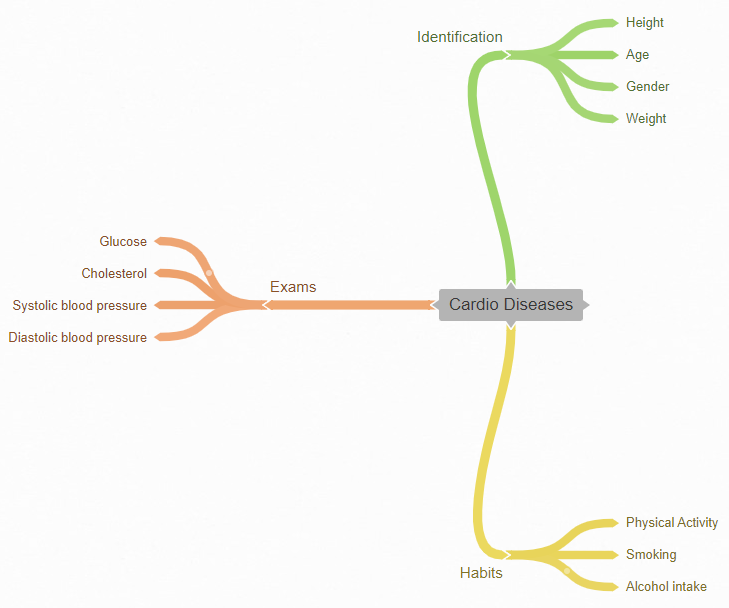

In [14]:
Image('CCD.png')

## 2.2 Hypothesis Creation

### 2.1.1 Identification Hypothesis

**1.** People over 50 are on average 20% more likely to have CVD than under 50

**2.** People shorter than 170 cm (5'7'') have a 5% more chance of CVDs than over 170 cm

**3.** Men are 30% more likely than women to develop a CVD

**4.** People over 100 kg (220 lb) have 40% more chance of having a CVD than 100 kg

**5.** People with a BMI above 30 (obese class I) have 25% more chance of having a CVD than below 30

### 2.1.2 Habits Hypothesis

**1.** People who do not engage in physical activity are 40% more likely to have CVDs than who engage

**2.** People who regularly consume alcohol have a 10% chance of having CVD than those who do not consume

**3.** People who smoke are 20% more likely to have CVD than who do not smoke

### 2.1.3 Exams Hypothesis

**1.** People with well above normal cholesterol have a 50% chance of having CVD than normal

**2.** People with well above normal glucose have a 20% chance of having CVD than normal

**3.** People who have hypertension have 40% chance of having CVD than who have normal blood pressure

## 2.3. Final Hypothesis

**1.** People over 50 are on average 20% more likely to have CVD than under 50

**2.** People shorter than 170 cm (5'7'') have a 5% more chance of CVDs than over 170 cm

**3.** Men are 30% more likely than women to develop a CVD

**4.** People over 100 kg (220 lb) have 40% more chance of having a CVD than 100 kg

**5.** People with a BMI above 30 (obese class I) have 25% more chance of having a CVD than below 30

**6.** People who do not engage in physical activity are 40% more likely to have CVDs than who engage

**7.** People who regularly consume alcohol have a 10% chance of having CVD than those who do not consume

**8.** People who smoke are 20% more likely to have CVD than who do not smoke

**9.** People with well above normal cholesterol have a 50% chance of having CVD than normal

**10.** People with well above normal glucose have a 20% chance of having CVD than normal

**11.** People who have hypertension have 40% chance of having CVD than who have normal blood pressure

## 2.4. Feature Engineering

In [15]:
#BMI
df2['bmi'] = bmi(df2['height'], df2['weight'])
df2['bmi'] = df2['bmi'].astype(int)

In [16]:
#blood pressure classification
df2['blood_pressure'] = ''

df2['blood_pressure'] = df2.apply(lambda x: '0' if (x['ap_hi'] > 0 and x['ap_hi'] < 120) and (x['ap_lo'] > 0 and x['ap_lo'] < 80) else '' 
                                  '1' if (x['ap_hi'] >= 120 and x['ap_hi'] <= 129) and (x['ap_lo'] < 80) else ''
                                  '2' if (x['ap_hi'] >= 130 and x['ap_hi'] <= 139) or (x['ap_lo'] >= 80 and x['ap_lo'] <= 89) else ''
                                  '3' if (x['ap_hi'] >= 140 and x['ap_hi'] <= 179) or (x['ap_lo'] >= 90 and x['ap_lo'] <= 119) else ''
                                  '4' if x['ap_hi'] >= 180 or x['ap_lo'] >= 120 else '', axis=1)

#remove na
df2['blood_pressure'] = df2['blood_pressure'].replace('',  )
df2['blood_pressure'] = df2['blood_pressure'].dropna()

#transform to (int)
df2['blood_pressure'] = pd.to_numeric(df2['blood_pressure'],errors = 'coerce')

In [17]:
df2.dtypes

id                int64
age               int32
gender            int64
height            int64
weight            int32
ap_hi             int64
ap_lo             int64
cholesterol       int64
gluc              int64
smoke             int64
alco              int64
active            int64
cardio            int64
bmi               int32
blood_pressure    int64
dtype: object

# 3.0. Data Filtering

In [18]:
df3 = df2.copy()
df3_full = df2.copy()

In [19]:
#blood pressure
#df3 = df3[~df3['blood_pressure'].isna()]

#height
#df3 = df3[(df3['height'] >= 140) & (df3['height'] <= 200)]

#weight
#df3 = df3[(df3['weight'] >= 50) & (df3['weight'] <= 150)]

#ap_hi
#df3 = df3[(df3['ap_hi'] >= 0) & (df3['ap_hi'] <= 250)]

#ap_lo
#df3 = df3[(df3['ap_lo'] >= 0) & (df3['ap_lo'] <= 250)]

In [20]:
#central tendency - mean, median
ct1 = pd.DataFrame(df3.apply(np.mean)).T
ct2 = pd.DataFrame(df3.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(df3.apply(min)).T
d2 = pd.DataFrame(df3.apply(max)).T
d3 = pd.DataFrame(df3.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(df3.apply(np.std)).T
d5 = pd.DataFrame(df3.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df3.apply(lambda x: x.kurtosis())).T
d7 = pd.DataFrame(df3.apply(lambda x: len(x))).T

#concatenate
m = pd.concat([d1,d2,d3,ct1,ct2,d4,d5,d6,d7]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis','total']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis,total
0,id,0.0,99999.0,99999.0,49997.226508,50025.0,28870.500843,-0.001370,-1.199779,63000.0
1,age,29.0,64.0,35.0,52.849778,53.0,6.764835,-0.306698,-0.817102,63000.0
2,gender,1.0,2.0,1.0,1.348984,1.0,0.476649,0.633672,-1.598511,63000.0
3,height,55.0,250.0,195.0,164.349127,165.0,8.230368,-0.674734,8.318001,63000.0
4,weight,11.0,200.0,189.0,74.240619,72.0,14.414142,1.002343,2.497744,63000.0
5,ap_hi,-150.0,16020.0,16170.0,129.055730,120.0,162.120360,81.237518,6858.540555,63000.0
6,ap_lo,-70.0,11000.0,11070.0,96.990540,80.0,190.820334,31.948589,1411.705386,63000.0
7,cholesterol,1.0,3.0,2.0,1.366508,1.0,0.680095,1.588783,0.998892,63000.0
8,gluc,1.0,3.0,2.0,1.226190,1.0,0.571864,2.399353,4.305065,63000.0
9,smoke,0.0,1.0,1.0,0.088317,0.0,0.283756,2.901735,6.420267,63000.0


In [21]:
#calculate summary statistics
data_mean, data_std = m['mean'][3], m['std'][3]
#identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
#identify outliers
df3['outliers'] = ''
df3['outliers'] = df3.apply(lambda x: 'outlier' if (x['height'] < lower or x['height'] > upper) else '', axis=1)

#remove outliers
df3 = df3[(df3['outliers'] != 'outlier')]

In [22]:
#calculate summary statistics
data_mean, data_std = m['mean'][4], m['std'][4]
#identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
#identify outliers
df3['outliers'] = ''
df3['outliers'] = df3.apply(lambda x: 'outlier' if (x['weight'] < lower or x['weight'] > upper) else '', axis=1)

#remove outliers
df3 = df3[(df3['outliers'] != 'outlier')]

In [23]:
#calculate summary statistics
data_mean, data_std = m['mean'][5], m['std'][5]
#identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
#identify outliers
df3['outliers'] = ''
df3['outliers'] = df3.apply(lambda x: 'outlier' if (x['ap_hi'] < lower or x['ap_hi'] > upper) else '', axis=1)

#remove outliers
df3 = df3[(df3['outliers'] != 'outlier')]

In [24]:
#calculate summary statistics
data_mean, data_std = m['mean'][6], m['std'][6]
#identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
#identify outliers
df3['outliers'] = ''
df3['outliers'] = df3.apply(lambda x: 'outlier' if (x['ap_lo'] < lower or x['ap_lo'] > upper) else '', axis=1)

#remove outliers
df3 = df3[(df3['outliers'] != 'outlier')]

In [25]:
#calculate summary statistics
data_mean, data_std = m['mean'][13], m['std'][13]
#identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
#identify outliers
df3['outliers'] = ''
df3['outliers'] = df3.apply(lambda x: 'outlier' if (x['bmi'] < lower or x['bmi'] > upper) else '', axis=1)

#remove outliers
df3 = df3[(df3['outliers'] != 'outlier')]

df3 = df3.drop('outliers', 1)

<ipython-input-25-ee8f72e6fa0e>:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df3 = df3.drop('outliers', 1)


In [26]:
#central tendency - mean, median
ct1 = pd.DataFrame(df3.apply(np.mean)).T
ct2 = pd.DataFrame(df3.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(df3.apply(min)).T
d2 = pd.DataFrame(df3.apply(max)).T
d3 = pd.DataFrame(df3.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(df3.apply(np.std)).T
d5 = pd.DataFrame(df3.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df3.apply(lambda x: x.kurtosis())).T
d7 = pd.DataFrame(df3.apply(lambda x: len(x))).T

#concatenate
m = pd.concat([d1,d2,d3,ct1,ct2,d4,d5,d6,d7]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis','total']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis,total
0,id,0.0,99999.0,99999.0,49989.754099,50030.0,28863.133742,-0.000967,-1.198923,61179.0
1,age,29.0,64.0,35.0,52.837755,53.0,6.765629,-0.304700,-0.818782,61179.0
2,gender,1.0,2.0,1.0,1.347390,1.0,0.476141,0.641042,-1.589117,61179.0
3,height,140.0,189.0,49.0,164.395855,165.0,7.703037,0.095399,-0.080235,61179.0
4,weight,31.0,117.0,86.0,73.545743,72.0,13.156018,0.527847,0.160427,61179.0
5,ap_hi,-150.0,401.0,551.0,126.182236,120.0,17.898611,-0.111016,10.310841,61179.0
6,ap_lo,-70.0,602.0,672.0,81.297243,80.0,10.279602,4.310006,207.192028,61179.0
7,cholesterol,1.0,3.0,2.0,1.361251,1.0,0.676552,1.611318,1.074546,61179.0
8,gluc,1.0,3.0,2.0,1.222985,1.0,0.568722,2.425031,4.431614,61179.0
9,smoke,0.0,1.0,1.0,0.087514,0.0,0.282586,2.919436,6.523322,61179.0


# 4.0. Exploratory Data Analysis

In [27]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response variable

In [28]:
#sns.displot(df4['cardio'], kde=True)

### 4.1.2 Numeric variable

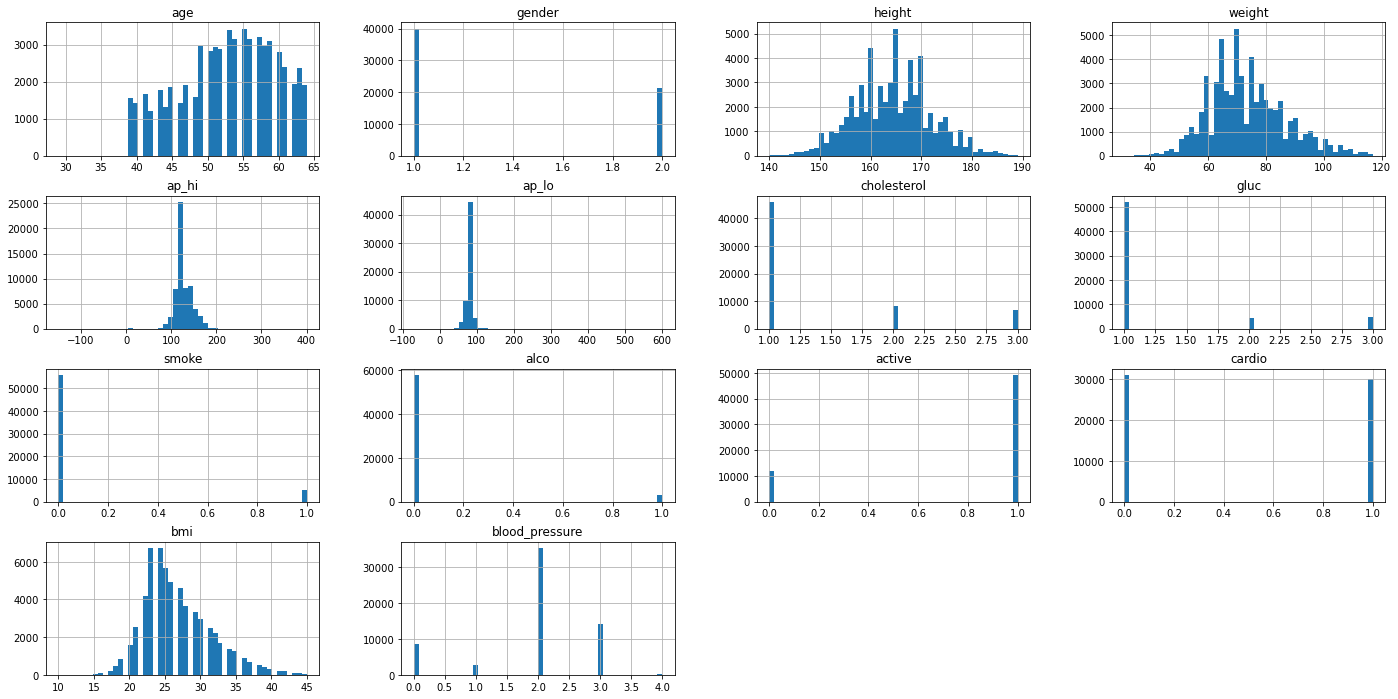

In [29]:
df42 = df4.drop('id', axis=1)
df42.hist(figsize=(24,12), bins=50);

## 4.2. Bivariate Analysis

**1. Analysis between 39 - 64. People over 50 are on average 20% more likely to have CVD than under 50**

**TRUE** On average people over 50 are 56.6% likely to have CVD and 20.9% more likely than under 50. 63 years old has the highest incidence.

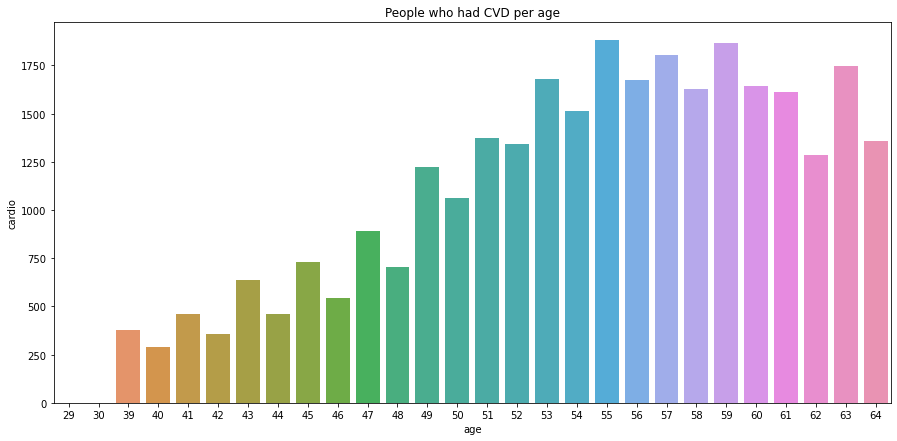

In [30]:
#cvd per age
aux1 = df4[['age', 'cardio']].groupby('age').sum().reset_index().rename(columns={0:'total'})

#histogram
fig_dims = (15, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='age', y='cardio', ax=ax, data=aux1)
plt.title('People who had CVD per age')
plt.show()

In [31]:
#% people with CVD per age
aux1 = df4[(df4['age'] >= 39)]
aux1 = aux1[['age', 'cardio']].groupby(['age','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

<ipython-input-3-aef4631f8147>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


In [32]:
#divide bewtween two groups under and over 50
aux1 = aux1[(aux1['cardio'] >= 1)]
aux_50 = aux1[(aux1['age'] >= 50)]
aux_50 = pd.DataFrame(aux_50.apply(np.mean)).T

aux_49 = aux1[(aux1['age'] < 50)]
aux_49 = pd.DataFrame(aux_49.apply(np.mean)).T

#result of average
m = pd.concat([aux_50, aux_49]).T.reset_index()
m.columns = ['index','over 50','under 50']
m['index'] = {'age': 0, 'cardio': 1, 'total': 2, 'average': 3}
m

,index,over 50,under 50
0,age,57.000000,44.000000
1,cardio,1.000000,1.000000
2,total,1564.466667,607.272727
3,average,56.274273,34.815268


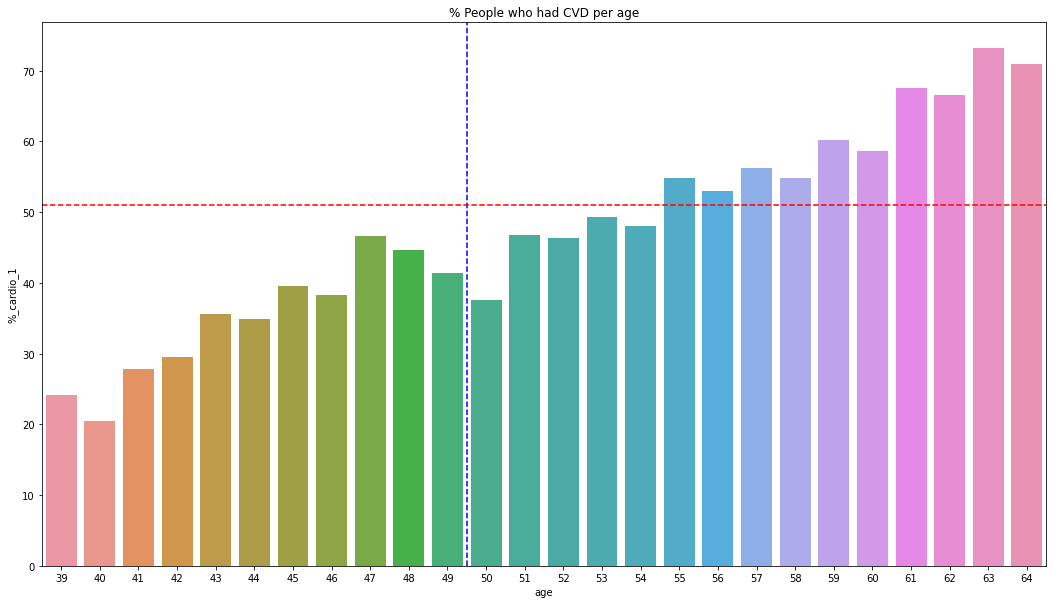

In [33]:
#histogram people who had CVD per age
fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='age', y='%_cardio_1', ax=ax, data=aux1)
graph.axvline(10.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per age')
plt.show()

**2. Analysis between 140 - 193 cm. People shorter than 170 cm (5'7'') have a 5% more chance of CVDs than over 170 cm**

**FALSE** On average people shorter than 170 cm have 4.5% more likely to have CVD than over 170.

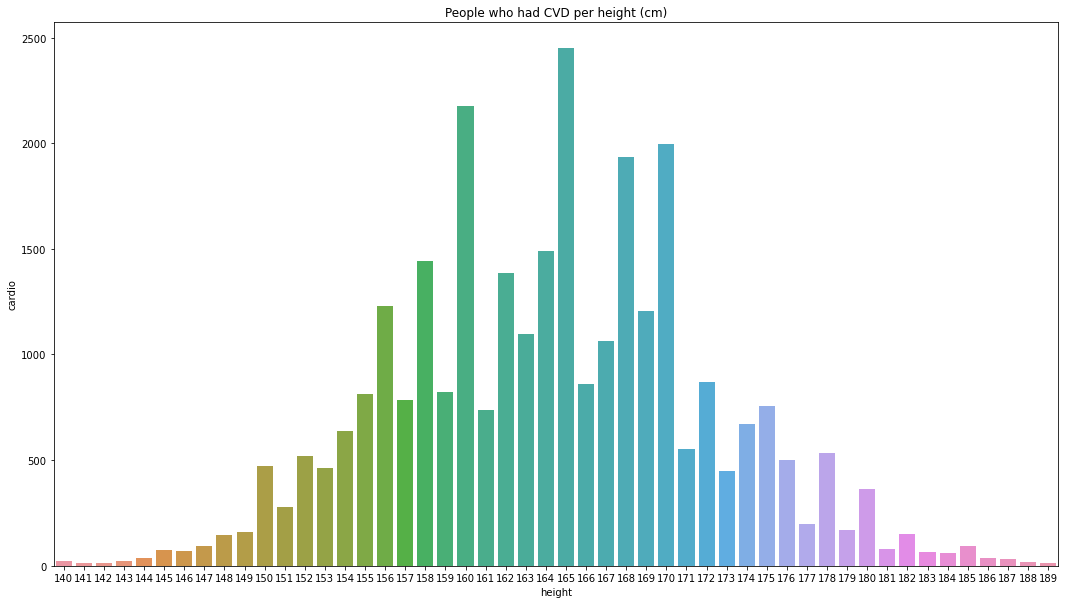

In [34]:
#cvd per height
aux1 = df4[(df4['height'] >= 140) & (df4['height'] <= 193)]
aux1 = aux1[['height', 'cardio']].groupby('height').sum().reset_index()

#histogram
fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='height', y='cardio', ax=ax, data=aux1)
plt.title('People who had CVD per height (cm)')
plt.show()

In [35]:
#filter height 140 - 190 and divide between two groups
#aux1 = df4[(df4['cardio'] >= 1) & (df4['height'] >= 140) & (df4['height'] <= 190)]
#aux1 = aux1[['height', 'cardio']].groupby('height').size().reset_index().rename(columns={0:'total_1'})

#aux2 = df4[(df4['cardio'] <= 0) & (df4['height'] >= 140) & (df4['height'] <= 190)]
#aux2 = aux2[['height', 'cardio']].groupby('height').size().reset_index().rename(columns={0:'total_0'})

#fig = plt.figure(figsize=(10,10))

#ax = fig.add_subplot(111)

#width = 0.2

#aux1.plot(x='height', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
#aux2.plot(x='height', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
#plt.show()

In [36]:
#filtering and calculate % people with CVD per height
aux1 = df4[(df4['height'] >= 135) & (df4['height'] <= 193)]
aux1 = aux1[['height', 'cardio']].groupby(['height','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

<ipython-input-3-aef4631f8147>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


In [37]:
#divide bewtween two groups below and over 170
aux1 = aux1[(aux1['cardio'] >= 1)]
aux_170 = aux1[(aux1['height'] >= 170)]
aux_170 = pd.DataFrame(aux_170.apply(np.mean)).T

aux_169 = aux1[(aux1['height'] < 170)]
aux_169 = pd.DataFrame(aux_169.apply(np.mean)).T

#result of average
m = pd.concat([aux_170, aux_169]).T.reset_index()
m.columns = ['index','over 170','below 169']
m['index'] = {'age': 0, 'cardio': 1, 'total': 2, 'average': 3}
m

,index,over 170,below 169
0,age,179.500000,154.500000
1,cardio,1.000000,1.000000
2,total,380.850000,751.000000
3,average,48.713953,52.032748


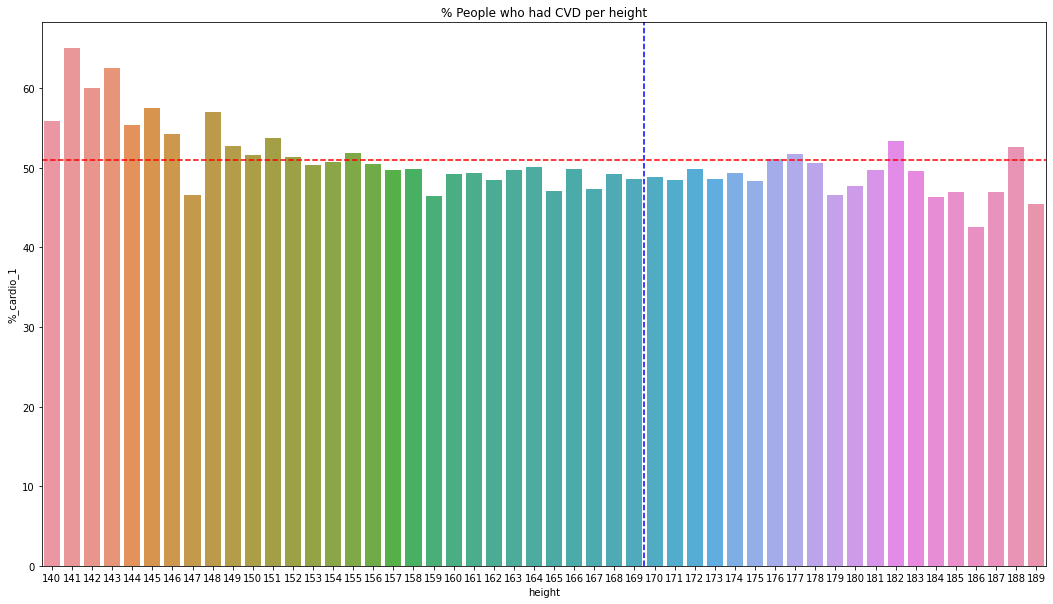

In [38]:
#histogram people who had CVD per height
fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='height', y='%_cardio_1', ax=ax, data=aux1)
graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per height')
plt.show()

**3. Men are 30% more likely than women to develop a CVD**

**FALSE** Although men had more CVD than women, the gap are lesser than 30%. Men had 50,1% of cases of CVD, while women had 49,6%

In [39]:
#transform to categorical
df42 = df4.copy()
df42['gender'] = df42['gender'].apply({1:'women', 2:'men'}.get)

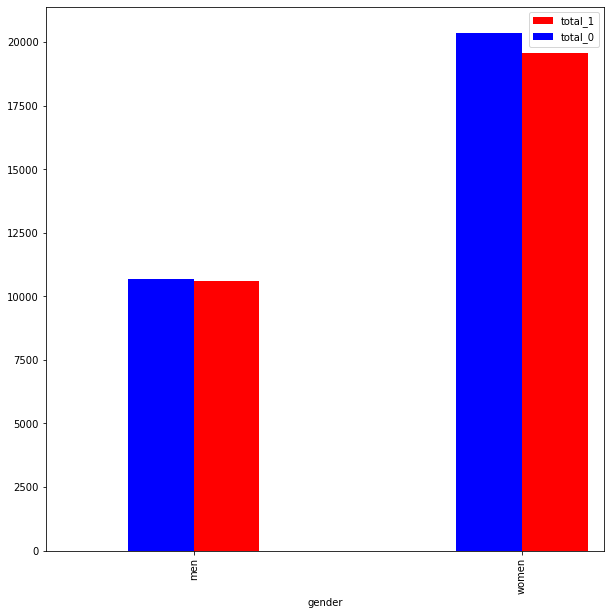

In [40]:
#cvd per height
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['gender', 'cardio']].groupby('gender').size().reset_index().rename(columns={0:'total_1'})

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['gender', 'cardio']].groupby('gender').size().reset_index().rename(columns={0:'total_0'})

#histogram
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='gender', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='gender', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [41]:
#calculate % people with CVD per gender
aux1 = df42[['gender', 'cardio']].groupby(['gender','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

#result of %
aux1 = aux1[(aux1['cardio'] >= 1)]
aux1

<ipython-input-3-aef4631f8147>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


,gender,cardio,total,%_cardio_1
1,men,1,10588,49.818849
3,women,1,19559,48.988128


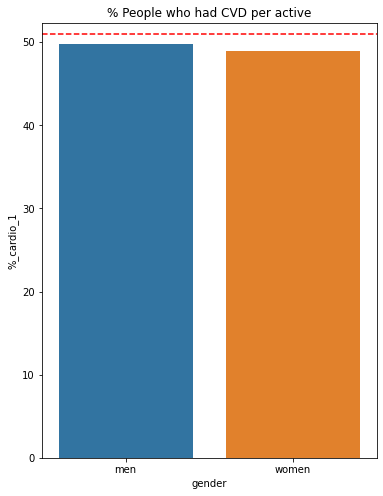

In [42]:
#histogram people who had CVD per gender (average)
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='gender', y='%_cardio_1', ax=ax, data=aux1)
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per active')
plt.show()

**4. Analysis between 50 - 130. People over 100 kg (220 lb) have 40% more chance of having a CVD than 100 kg**

**FALSE** On average people with over 100 kg have 19.9% more chance of having a CVD than below 100 kg

<AxesSubplot:xlabel='weight', ylabel='cardio'>

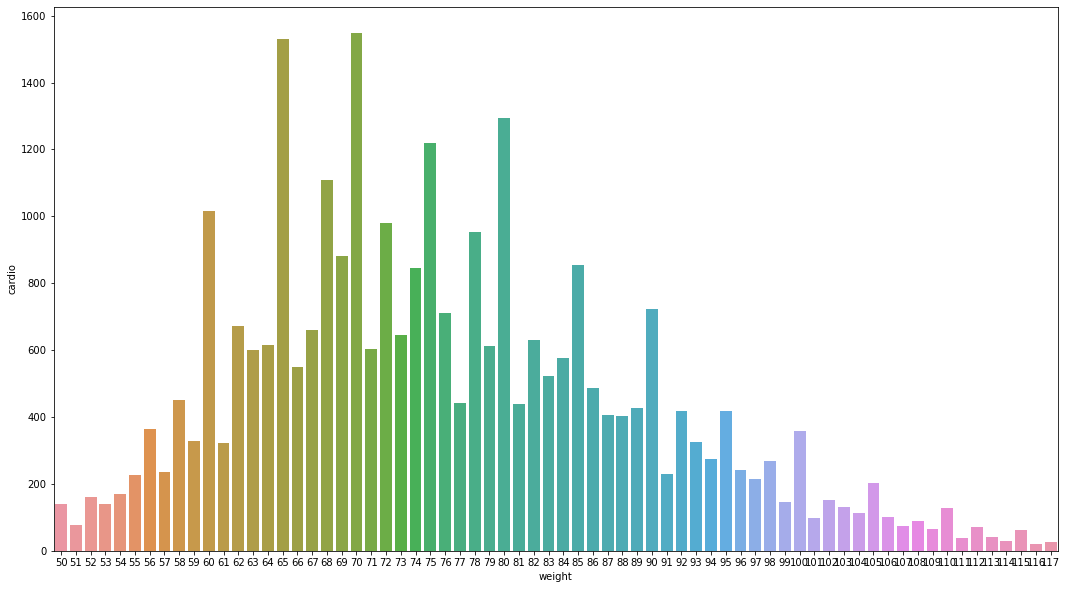

In [43]:
#cvd per weight
aux1 = df4[(df4['weight'] >= 50) & (df4['weight'] <= 130)]
aux1 = aux1[['weight', 'cardio']].groupby('weight').sum().reset_index()

#histogram
fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='weight', y='cardio', ax=ax, data=aux1)

In [44]:
#filter weight 33 - 100 and divide between two groups
#aux1 = df4[(df4['weight'] >= 33) & (df4['weight'] <= 100) & (df4['cardio'] >= 1)]
#aux1 = aux1[['weight', 'cardio']].groupby('weight').size().reset_index().rename(columns={0:'total_1'})

#aux2 = df4[(df4['weight'] >= 33) & (df4['weight'] <= 100) & (df4['cardio'] <= 0)]
#aux2 = aux2[['weight', 'cardio']].groupby('weight').size().reset_index().rename(columns={0:'total_0'})

In [45]:
#filtering and calculate % people with CVD per weight
aux1 = df4[(df4['weight'] >= 50) & (df4['weight'] <= 130)]
aux1 = aux1[['weight', 'cardio']].groupby(['weight','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

<ipython-input-3-aef4631f8147>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


In [46]:
#divide bewtween two groups below and over 100 kg
aux1 = aux1[(aux1['cardio'] >=1)]
aux_100 = aux1[(aux1['weight'] >= 100)]
aux_100 = pd.DataFrame(aux_100.apply(np.mean)).T

aux_99 = aux1[(aux1['weight'] < 100)]
aux_99 = pd.DataFrame(aux_99.apply(np.mean)).T

#result of average
m = pd.concat([aux_100, aux_99]).T.reset_index()
m.columns = ['index','over 100','below 100']
m['index'] = {'age': 0, 'cardio': 1, 'total': 2, 'average': 3}
m

,index,over 100,below 100
0,age,108.500000,74.500000
1,cardio,1.000000,1.000000
2,total,100.222222,562.180000
3,average,68.452806,49.898067


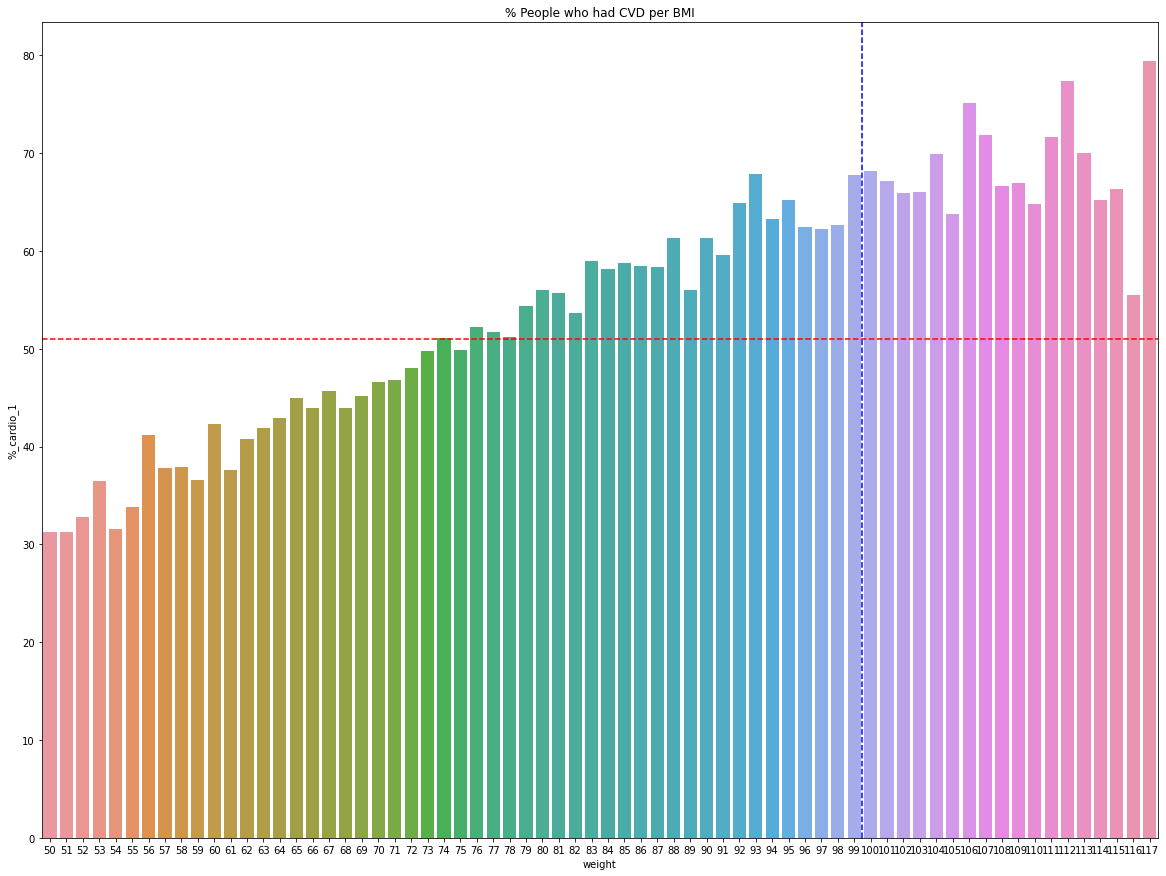

In [47]:
#histogram people who had CVD per height
fig_dims = (20,15)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='weight', y='%_cardio_1', ax=ax, data=aux1)
graph.axvline(49.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per BMI')
plt.show()

**5. People with a BMI above 30 (obese class I) have 25% more chance of having a CVD than below 30**

**TRUE** People with a BMI above than 30 have 26.3% chance of having CVD than BMI below 30

In [48]:
#convert type bmi (int)
df4['bmi'] = df4['bmi'].astype(int)

<AxesSubplot:xlabel='bmi', ylabel='cardio'>

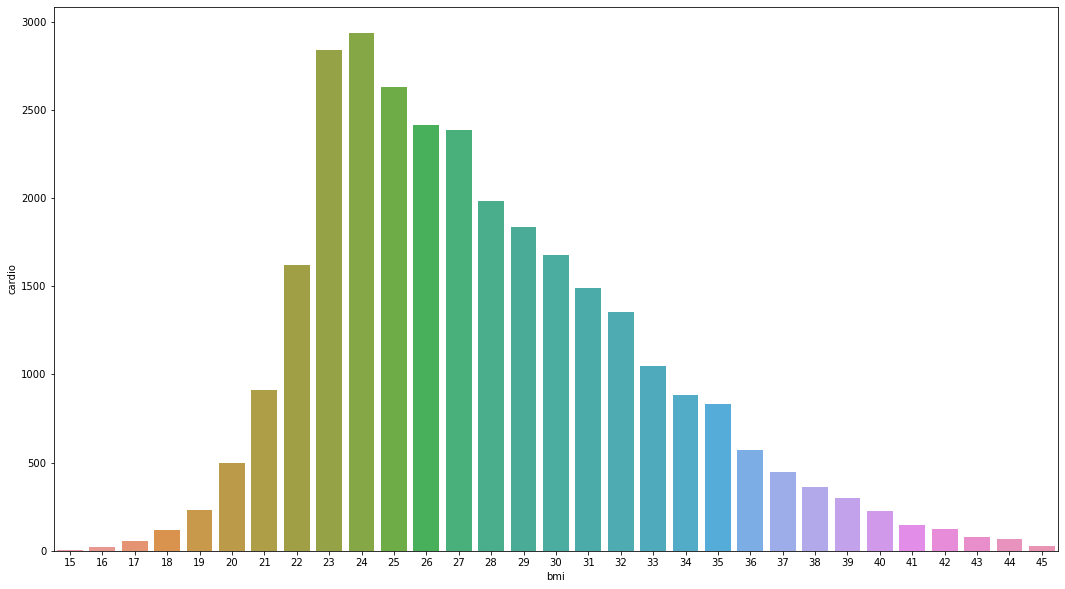

In [49]:
#cvd per weight
aux1 = df4[(df4['bmi'] >= 15) & (df4['bmi'] <= 50)]
aux1 = aux1[['bmi', 'cardio']].groupby('bmi').sum().reset_index()

#histogram
fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='bmi', y='cardio', ax=ax, data=aux1)

In [50]:
#calculate % people with CVD per bmi
aux1 = df4[(df4['bmi'] >= 15) & (df4['bmi'] <= 50)]
aux1 = aux1[['bmi', 'cardio']].groupby(['bmi','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

<ipython-input-3-aef4631f8147>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


In [51]:
#divide between two groups below and over 30
aux1 = aux1[(aux1['cardio'] >=1)]
aux_30 = aux1[(aux1['bmi'] >= 30)]
aux_30 = pd.DataFrame(aux_30.apply(np.mean)).T

aux_29 = aux1[(aux1['bmi'] < 30)]
aux_29 = pd.DataFrame(aux_29.apply(np.mean)).T

#result of average
m = pd.concat([aux_30, aux_29]).T.reset_index()
m.columns = ['index','over 30','above 30']
m['index'] = {'age': 0, 'cardio': 1, 'total': 2, 'average': 3}
m

,index,over 30,above 30
0,age,37.500000,22.000000
1,cardio,1.000000,1.000000
2,total,602.312500,1366.866667
3,average,65.478304,38.059989


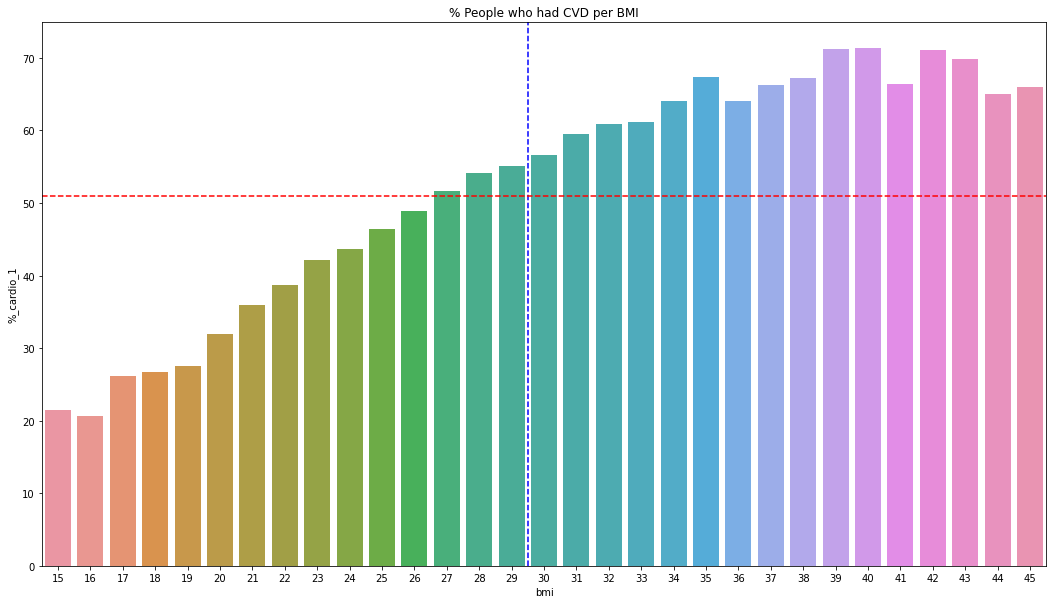

In [52]:
#histogram people who had CVD per BMI
fig_dims = (18, 10)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='bmi', y='%_cardio_1', ax=ax, data=aux1)
graph.axvline(14.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per BMI')
plt.show()

**6. People who do not engage in physical activity are 40% more likely to have CVDs than who engage**

**FALSE** People who engage in physical activity more have 4.6% chance of having CVD

In [53]:
#transform to categorical
df42 = df4.copy()
df42['active'] = df42['active'].apply({0:'no', 1:'yes'}.get)

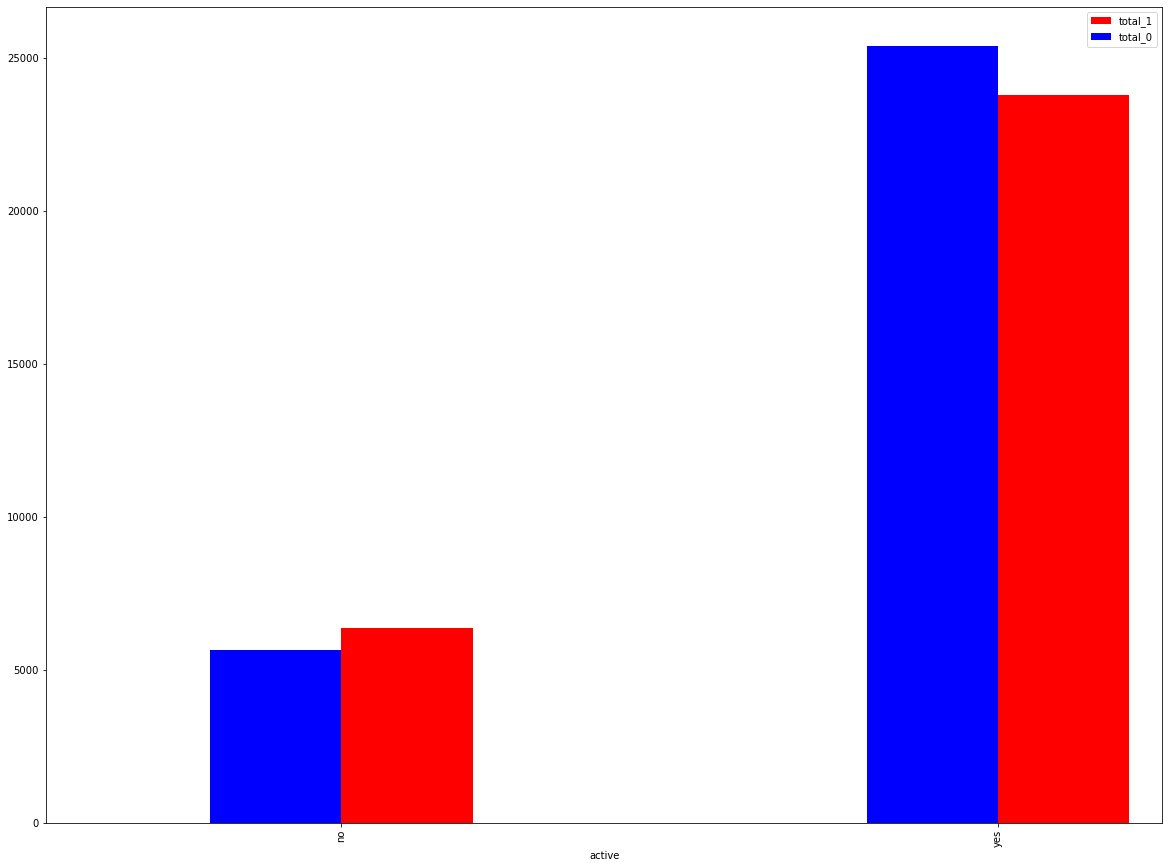

In [54]:
#cvd per physical activity
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['active', 'cardio']].groupby('active').size().reset_index().rename(columns={0:'total_1'})

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['active', 'cardio']].groupby('active').size().reset_index().rename(columns={0:'total_0'})

#histogram
fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='active', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='active', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [55]:
#calculate % people with CVD per activity
aux1 = df4[['active', 'cardio']].groupby(['active','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

#result of %
aux1 = aux1[(aux1['cardio'] >= 1)]
aux1['active'] = aux1['active'].apply({0:'no', 1:'yes'}.get)
aux1

<ipython-input-3-aef4631f8147>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


,active,cardio,total,%_cardio_1
1,no,1,6352,52.9819
3,yes,1,23795,48.373653


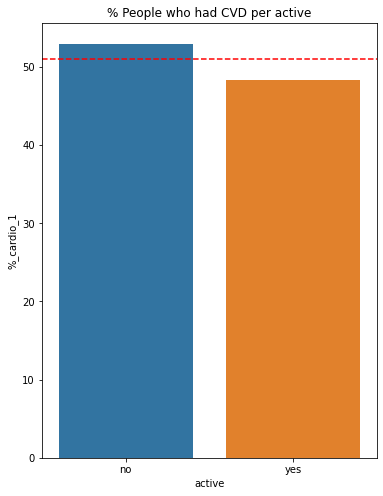

In [56]:
#histogram people who had CVD per activity
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='active', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per active')
plt.show()

**7. People who regularly consume alcohol have a 10% chance of having CVD than those who do not consume**

**FALSE** People who regularly consume alcohol have 1.9% less chance of having CVD than who don't consume

In [57]:
#transform to categorical
df42 = df4.copy()
df42['alco'] = df42['alco'].apply({0:'no', 1:'yes'}.get)

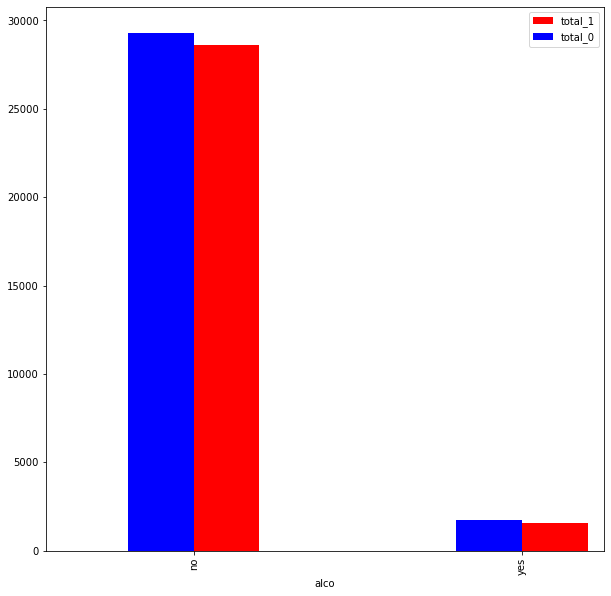

In [58]:
#cvd per people who consume alcohol
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['alco', 'cardio']].groupby('alco').size().reset_index().rename(columns={0:'total_1'})

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['alco', 'cardio']].groupby('alco').size().reset_index().rename(columns={0:'total_0'})

#histogram
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='alco', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='alco', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [59]:
#calculate % people with CVD per people who consume alcohol
aux1 = df42[['alco', 'cardio']].groupby(['alco','cardio']).size().reset_index().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

#result of %
aux1 = aux1[(aux1['cardio'] >= 1)]
aux1

<ipython-input-3-aef4631f8147>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


,index,alco,cardio,total,%_cardio_1
1,1,no,1,28596,49.392013
3,3,yes,1,1551,47.243375


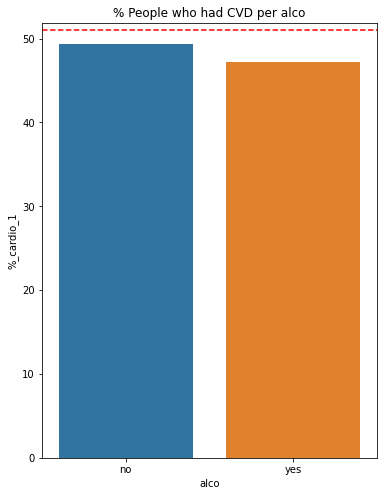

In [60]:
#histogram people who had CVD per per people who consume alcohol
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='alco', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per alco')
plt.show()

**8. People who smoke are 20% more likely to have CVD than who do not smoke**

**FALSE** People who smoke have 3% less chance of having CVD than who doesn't

In [61]:
#transform to categorical
df42 = df4.copy()
df42['smoke'] = df42['smoke'].apply({0:'no', 1:'yes'}.get)

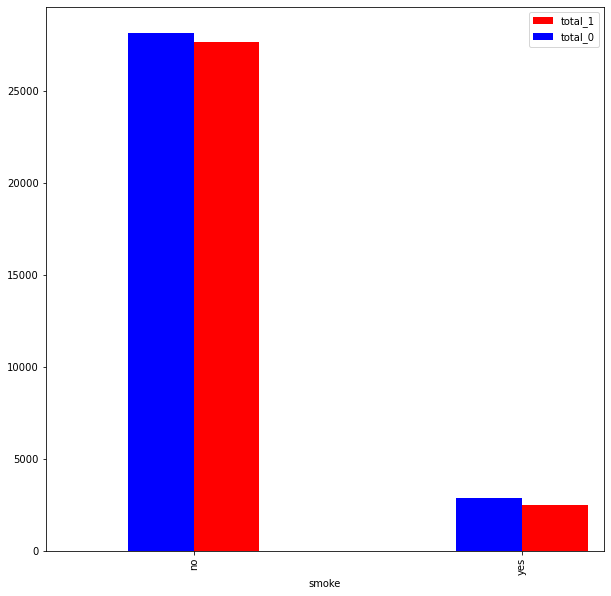

In [62]:
#cvd per people who smoke
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['smoke', 'cardio']].groupby('smoke').size().reset_index().rename(columns={0:'total_1'})

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['smoke', 'cardio']].groupby('smoke').size().reset_index().rename(columns={0:'total_0'})

#histogram
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='smoke', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='smoke', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [63]:
#calculate % people with CVD per people who smoke
aux1 = df42[['smoke', 'cardio']].groupby(['smoke','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

#result of %
aux1 = aux1[(aux1['cardio'] >= 1)]
aux1

<ipython-input-3-aef4631f8147>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


,smoke,cardio,total,%_cardio_1
1,no,1,27662,49.551276
3,yes,1,2485,46.413896


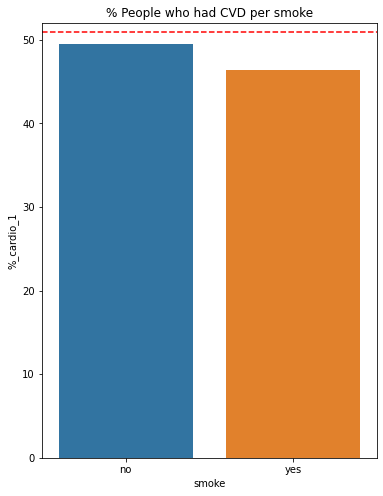

In [64]:
#histogram people who had CVD per people who smoke
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='smoke', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per smoke')
plt.show()

**9. People with well above normal cholesterol have a 50% chance of having CVD than normal**

**FALSE** People with well above normal cholesterol have 33% likely than people with normal

In [65]:
#transform to categorical
df42 = df4.copy()
df42['cholesterol'] = df42['cholesterol'].apply({1:'normal', 2:'above normal', 3:'well above normal'}.get)

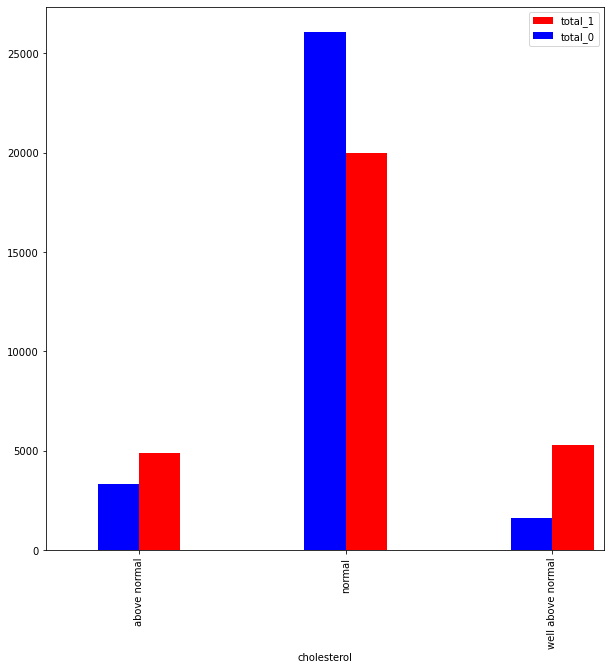

In [66]:
#cvd per people who have above normal cholesterol
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['cholesterol', 'cardio']].groupby('cholesterol').size().reset_index().rename(columns={0:'total_1'})

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['cholesterol', 'cardio']].groupby('cholesterol').size().reset_index().rename(columns={0:'total_0'})

#histogram
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='cholesterol', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='cholesterol', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [67]:
#calculate % people with CVD per people who have above normal cholesterol
aux1 = df42[['cholesterol', 'cardio']].groupby(['cholesterol','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

#result of %
aux1 = aux1[(aux1['cardio'] >= 1)]
aux1

<ipython-input-3-aef4631f8147>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


,cholesterol,cardio,total,%_cardio_1
1,above normal,1,4864,59.208764
3,normal,1,19979,43.41279
5,well above normal,1,5304,76.39349


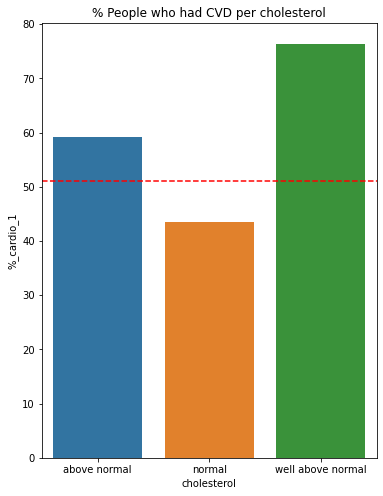

In [68]:
#histogram people who had CVD per people who have above normal cholesterol
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='cholesterol', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per cholesterol')
plt.show()

**10. People with well above normal glucose have a 20% chance of having CVD than normal**

**FALSE** People with well above normal glucose have 14.1% more likely than people with normal glucose

In [69]:
#transform to categorical
df42 = df4.copy()
df42['gluc'] = df42['gluc'].apply({1:'normal', 2:'above normal', 3:'well above normal'}.get)

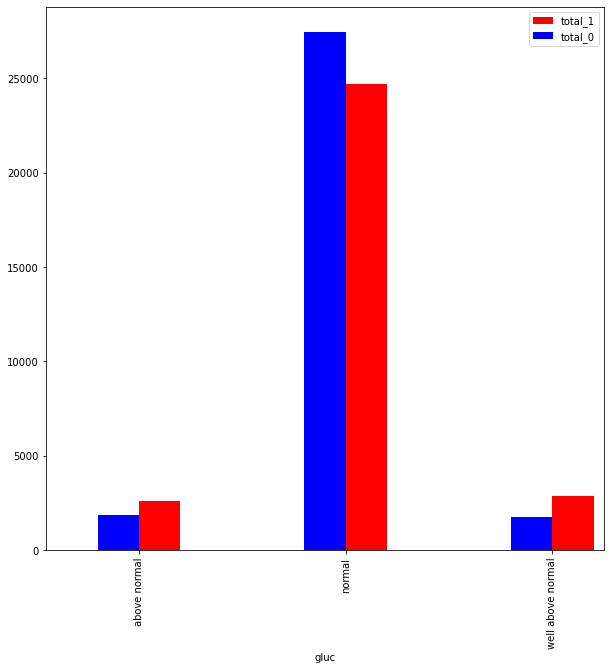

In [70]:
#cvd per people who have above normal glucose
aux1 = df42[(df42['cardio'] >= 1)]
aux1 = aux1[['gluc', 'cardio']].groupby('gluc').size().reset_index().rename(columns={0:'total_1'})

aux2 = df42[(df42['cardio'] <= 0)]
aux2 = aux2[['gluc', 'cardio']].groupby('gluc').size().reset_index().rename(columns={0:'total_0'})

#histogram
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='gluc', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='gluc', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [71]:
#calculate % people with CVD per people who have above normal glucose
aux1 = df42[['gluc', 'cardio']].groupby(['gluc','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

#result of %
aux1 = aux1[(aux1['cardio'] >= 1)]
aux1

<ipython-input-3-aef4631f8147>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


,gluc,cardio,total,%_cardio_1
1,above normal,1,2594,58.239784
3,normal,1,24709,47.397901
5,well above normal,1,2844,61.906835


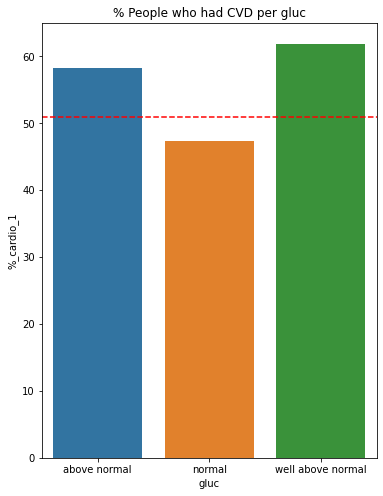

In [72]:
#histogram people who had CVD per people who have above normal glucose
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='gluc', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per gluc')
plt.show()

**11. People who have hypertension have 40% chance of having CVD than who have normal blood pressure**

**TRUE** People with hypertension 3 have 54.2% more chance of having a CVD than people with normal blood pressure

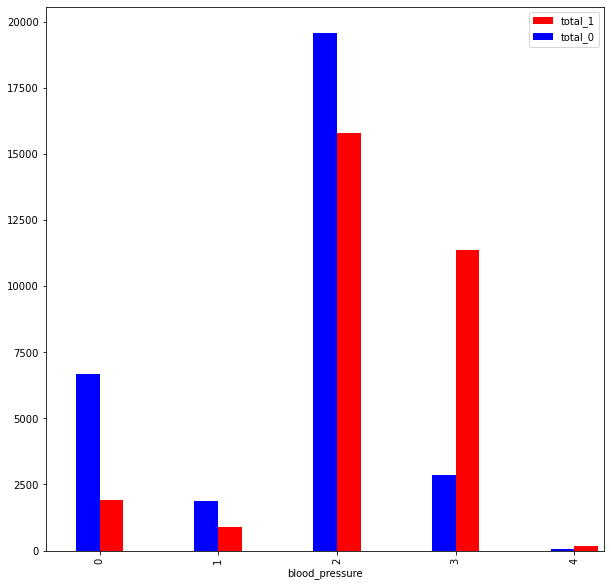

In [73]:
#cvd per people who have hypertension
aux1 = df4[(df4['cardio'] >= 1)]
aux1 = aux1[['blood_pressure', 'cardio']].groupby('blood_pressure').size().reset_index().rename(columns={0:'total_1'})


aux2 = df4[(df4['cardio'] <= 0)]
aux2 = aux2[['blood_pressure', 'cardio']].groupby('blood_pressure').size().reset_index().rename(columns={0:'total_0'})

#histogram
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

width = 0.2

aux1.plot(x='blood_pressure', y='total_1', kind='bar', color='red', ax=ax, width=width, position=0)
aux2.plot(x='blood_pressure', y='total_0', kind='bar', color='blue', ax=ax, width=width, position=1)
plt.show()

In [74]:
#calculate % people with CVD per people who have hypertension
aux1 = df4[['blood_pressure', 'cardio']].groupby(['blood_pressure','cardio']).size().reset_index().rename(columns={0:'total'})
aux1['%_cardio_1'] = ""
aux1 = perc(aux1)

#result of %
aux1 = aux1[(aux1['cardio'] >= 1)]
aux1

<ipython-input-3-aef4631f8147>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['%_cardio_1'][i] = p


,blood_pressure,cardio,total,%_cardio_1
1,0,1,1905,22.20021
3,1,1,904,32.506293
5,2,1,15808,44.665461
7,3,1,11369,79.97327
9,4,1,161,77.033493


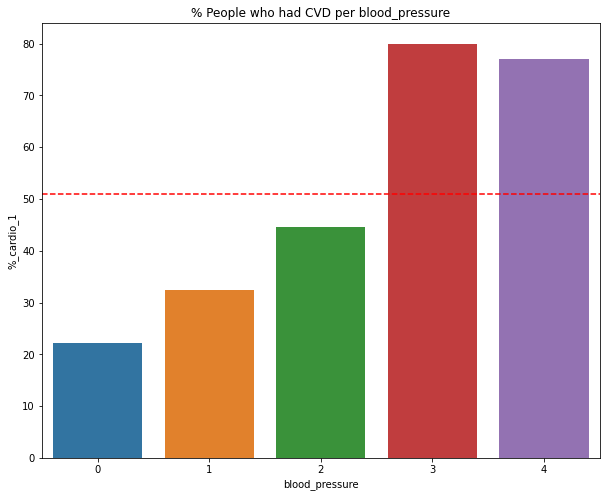

In [75]:
#histogram people who had CVD per people who have hypertension
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)

graph = sns.barplot(x='blood_pressure', y='%_cardio_1', ax=ax, data=aux1)
#graph.axvline(29.5, ymin=0.0, ymax=1.0, linestyle ="--", color='blue')
graph.axhline(51, xmin=0.0, xmax=1.0, linestyle ="--", color='red')
plt.title('% People who had CVD per blood_pressure')
plt.show()

## 4.3. Multivariate Analysis

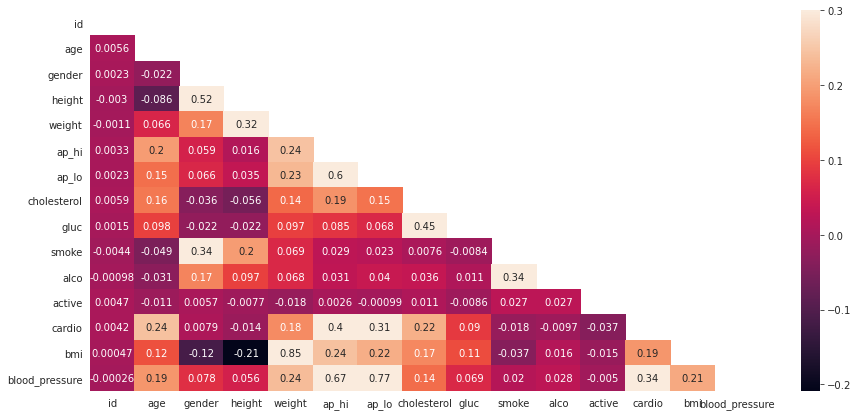

In [76]:
correlations = df4.corr(method='pearson')
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
#fig_dims = (15, 7)
#fig, ax = plt.subplots(figsize=fig_dims)
#sns.heatmap(correlations,ax=ax, annot=True);

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 7))
    ax = sns.heatmap(correlations, mask=mask, vmax=.3, annot=True)

# 5.0. Data Preparation

In [77]:
df5 = df4.copy()

In [78]:
x = df4.drop('cardio', axis=1)
y = df4['cardio'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(x,y, test_size = 0.20)
df5 = pd.concat([x_train, y_train], axis=1)

## 5.1. Normalization

In [79]:
# define min max scaler
scaler_mm = MinMaxScaler()
scaler_std = StandardScaler()

# transform weight - STD
df5['weight'] = scaler_mm.fit_transform(df5[['weight']].values)

# transform height - STD
df5['height'] = scaler_mm.fit_transform(df5[['height']].values)

# transform age - MM
df5['age'] = scaler_mm.fit_transform(df5[['age']].values)

# transform bmi - MM
df5['bmi'] = scaler_mm.fit_transform(df5[['bmi']].values)

# transform ap_hi - MM
df5['ap_hi'] = scaler_mm.fit_transform(df5[['ap_hi']].values)

# transform ap_lo - MM
df5['ap_lo'] = scaler_mm.fit_transform(df5[['ap_lo']].values)

#df5

## 5.2. Validation Preparation

In [80]:
# define min max scaler
scaler_mm = MinMaxScaler()
scaler_std = StandardScaler()

# transform weight - STD
x_val.loc[:, 'weight'] = scaler_mm.fit_transform(x_val[['weight']].values)

# transform height - STD
x_val.loc[:, 'height'] = scaler_mm.fit_transform(x_val[['height']].values)

# transform age - MM
x_val.loc[:, 'age'] = scaler_mm.fit_transform(x_val[['age']].values)

# transform bmi - MM
x_val.loc[:, 'bmi'] = scaler_mm.fit_transform(x_val[['bmi']].values)

# transform ap_hi - MM
x_val.loc[:, 'ap_hi'] = scaler_mm.fit_transform(x_val[['ap_hi']].values)

# transform ap_lo - MM
x_val.loc[:, 'ap_lo'] = scaler_mm.fit_transform(x_val[['ap_lo']].values)

C:\Users\Henrique\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\Henrique\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\Henrique\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

# 6.0. Feature Selection

In [81]:
df6 = df5.copy()
df6_full = df3_full.copy()

## 6.1. Boruta as feature selector

In [82]:
#training and test dataset for Boruta
x_train_n = x_train.values
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	12
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
I

In [83]:
cols_selected = boruta.support_.tolist()

#best feature
x_train_fs = x_train
cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()
print('Columns selected: ',cols_selected_boruta)

#not selected from Boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
print('Columns not selected: ',cols_not_selected_boruta)

Columns selected:  ['ap_hi']
Columns not selected:  ['active', 'age', 'alco', 'ap_lo', 'blood_pressure', 'bmi', 'cholesterol', 'gender', 'gluc', 'height', 'id', 'smoke', 'weight']


## 6.2. Relieff Selection

In [85]:
fs = ReliefF(n_neighbors=100, n_features_to_keep=10)
x_train_relieff = fs.fit_transform(x.values, y.values)
print("(No. of tuples, No. of Columns before ReliefF) : "+str(df6.shape[0])+
      "\n(No. of tuples, No. of Columns after ReliefF) : "+str(x_train_relieff.shape))

(No. of tuples, No. of Columns before ReliefF) : 48943
(No. of tuples, No. of Columns after ReliefF) : (61179, 10)


In [86]:
x_train_relieff[3]

array([  2, 120,  80,   2,   1,   0,   0,   1,   1,  47], dtype=int64)

In [87]:
cols_selected_relief = ['gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc',
                        'smoke', 'alco', 'active', 'bmi', 'blood_pressure']

## 6.3. Lasso Selection

In [88]:
df6_ls = df6.drop('cardio', 1)
features = df6_ls.columns

<ipython-input-88-b50dbf625a46>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df6_ls = df6.drop('cardio', 1)


In [89]:
pipeline = Pipeline([('scaler',StandardScaler()),('model',Lasso())])

In [90]:
search = GridSearchCV(pipeline,{'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=0)

search.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error')

In [91]:
search.best_params_

{'model__alpha': 0.1}

In [92]:
coefficients = search.best_estimator_.named_steps['model'].coef_

In [93]:
importance = np.abs(coefficients)

In [94]:
cols_selected_lasso = np.array(features)[importance > 0]
print('Columns selected: ', cols_selected_lasso)

cols_not_selected_lasso = np.array(features)[importance == 0]
print('Columns not selected: ', cols_not_selected_lasso)

Columns selected:  ['age' 'ap_hi' 'blood_pressure']
Columns not selected:  ['id' 'gender' 'height' 'weight' 'ap_lo' 'cholesterol' 'gluc' 'smoke'
 'alco' 'active' 'bmi']


## DF Split

In [95]:
#drop id, ap_hi, ap_lo
#df6 = df6.drop(['id'], axis=1)
#df6_full = df6_full.drop(['id'], axis=1)
df6_boruta = df6['ap_hi']
df6_relief = df6[['gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc',
                        'smoke', 'alco', 'active', 'bmi', 'blood_pressure']]
df6_lasso = df6[['age', 'ap_hi', 'blood_pressure']]

X = df6.drop(['cardio'], axis=1)
Y = df6['cardio'].copy()

X_full = df6_full.drop(['cardio'], axis=1)
Y_full = df6_full['cardio'].copy()

X_boruta = df6_boruta
Y_boruta = df6['cardio'].copy()

X_relief = df6_relief
Y_relief = df6['cardio'].copy()

X_lasso = df6_lasso
Y_lasso = df6['cardio'].copy()

In [96]:
#split dataset into train and test
x_train, x_val, y_train, y_val = ms.train_test_split(X, Y, test_size=0.2, random_state=42)

#split dataset into train and test (with outlier)
x_train_full, x_val_full, y_train_full, y_val_full = ms.train_test_split(X_full, Y_full, test_size=0.2, random_state=42)

#split dataset into train and test (boruta)
x_train_boruta, x_val_boruta, y_train_boruta, y_val_boruta = ms.train_test_split(X_boruta, Y_boruta, test_size=0.2, random_state=42)

#split dataset into train and test (relief)
x_train_relief, x_val_relief, y_train_relief, y_val_relief = ms.train_test_split(X_relief, Y_relief, test_size=0.2, random_state=42)

#split dataset into train and test (lasso)
x_train_lasso, x_val_lasso, y_train_lasso, y_val_lasso = ms.train_test_split(X_lasso, Y_lasso, test_size=0.2, random_state=42)

# 7.0. Machine Learning Modeling

## 7.1. Baseline Model

In [97]:
#df without outlier
response_list = y_test.drop_duplicates().sort_values().tolist()
size = x_test.shape[0]
weights = df6['cardio'].value_counts(normalize=True).sort_index().tolist()

# prediction
yhat_random = random.choices(response_list,k=size,weights=weights)

#performance
random_result = ml_error('Baseline', y_test, yhat_random)
random_result

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,Baseline,0.503143,1.00528,0.709326,0.496857,0.49687,-0.006259


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

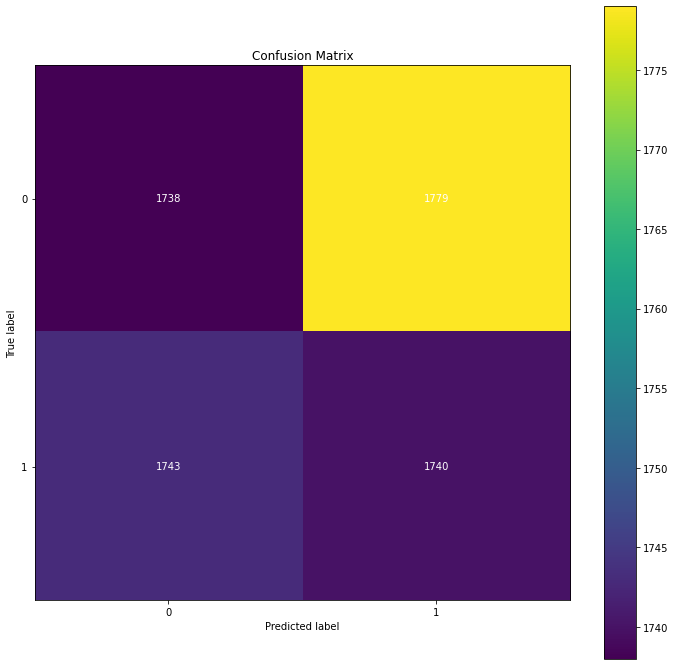

In [98]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_random,  cmap=plt.cm.viridis, normalize=False, figsize=(12,12))

In [101]:
#df full
response_list = y_val_full.drop_duplicates().sort_values().tolist()
size = x_val_full.shape[0]
weights = df6_full['cardio'].value_counts(normalize=True).sort_index().tolist()

# prediction
yhat_random_full = random.choices(response_list,k=size,weights=weights)

#performance
random_result_full = ml_error('Baseline', y_val_full, yhat_random_full)
random_result_full

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,Baseline,0.497857,0.991857,0.70559,0.502143,0.502153,0.004305


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

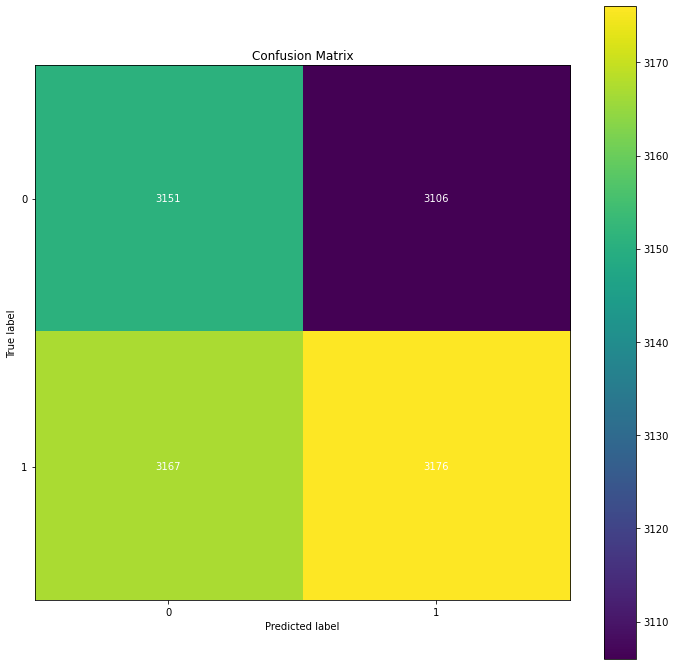

In [103]:
#confusion matrix
mt.plot_confusion_matrix(y_val_full, yhat_random_full,  cmap=plt.cm.viridis, normalize=False, figsize=(12,12))

In [104]:
#boruta
response_list = y_val_boruta.drop_duplicates().sort_values().tolist()
size = x_val_boruta.shape[0]
weights = df6['cardio'].value_counts(normalize=True).sort_index().tolist()

# prediction
yhat_random_boruta = random.choices(response_list,k=size,weights=weights)

#performance
random_result_boruta = ml_error('Baseline', y_val_boruta, yhat_random_boruta)
random_result_boruta

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,Baseline,0.495863,0.997432,0.704175,0.504137,0.504155,0.00831


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

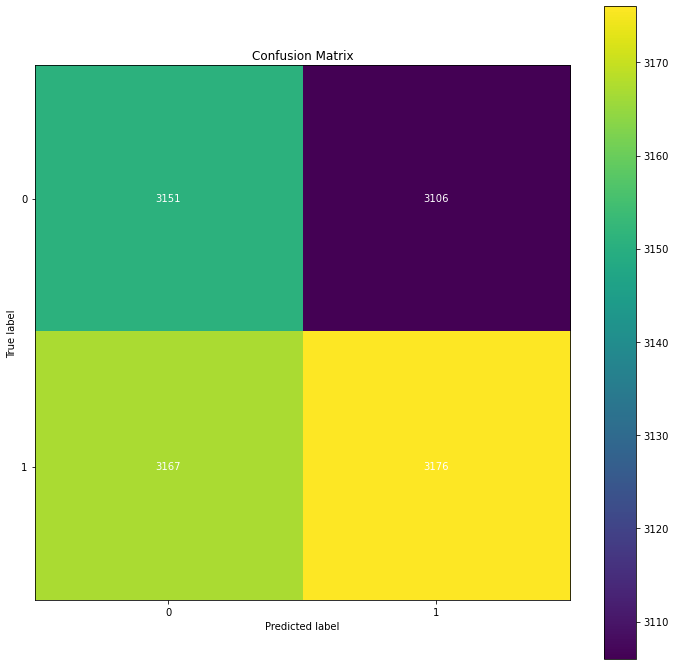

In [105]:
#confusion matrix
mt.plot_confusion_matrix(y_val_full, yhat_random_full,  cmap=plt.cm.viridis, normalize=False, figsize=(12,12))

In [106]:
#lasso
response_list = y_val_lasso.drop_duplicates().sort_values().tolist()
size = x_val_lasso.shape[0]
weights = df6['cardio'].value_counts(normalize=True).sort_index().tolist()

# prediction
yhat_random_lasso = random.choices(response_list,k=size,weights=weights)

#performance
random_result_lasso = ml_error('Baseline', y_val_lasso, yhat_random_lasso)
random_result_lasso

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,Baseline,0.494126,0.9919,0.702941,0.505874,0.505788,0.011577


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

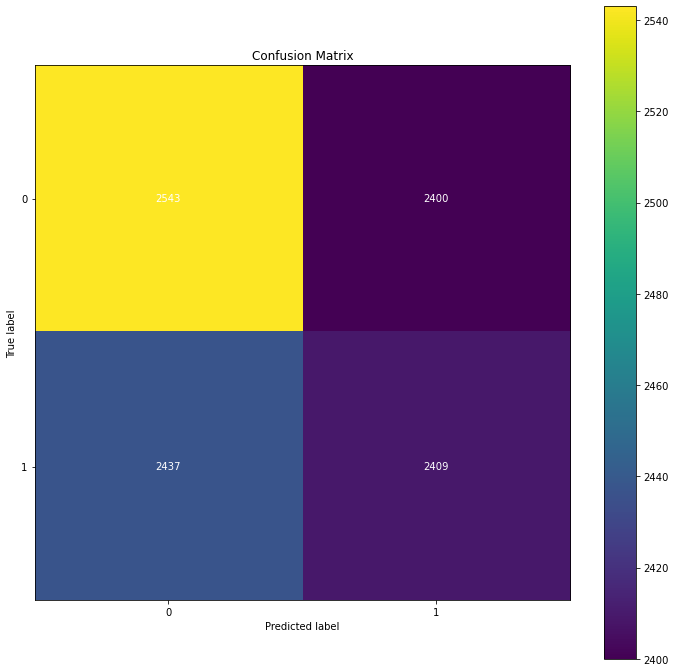

In [108]:
#confusion matrix
mt.plot_confusion_matrix(y_val_lasso, yhat_random_lasso,  cmap=plt.cm.viridis, normalize=False, figsize=(12,12))

In [109]:
#relief
response_list = y_val_relief.drop_duplicates().sort_values().tolist()
size = x_val_relief.shape[0]
weights = df6['cardio'].value_counts(normalize=True).sort_index().tolist()

# prediction
yhat_random_relief = random.choices(response_list,k=size,weights=weights)

#performance
random_result_relief = ml_error('Baseline', y_val_relief, yhat_random_relief)
random_result_relief

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,Baseline,0.49433,1.005508,0.703086,0.50567,0.50559,0.01118


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

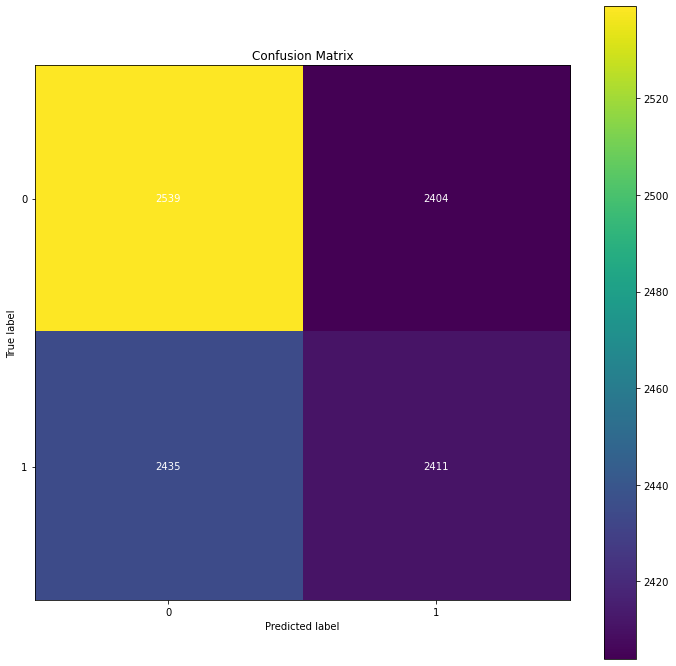

In [110]:
#confusion matrix
mt.plot_confusion_matrix(y_val_relief, yhat_random_relief,  cmap=plt.cm.viridis, normalize=False, figsize=(12,12))

## 7.2. Logistic Regression Model

In [111]:
#model
lg_model = lm.LogisticRegression(n_jobs=-1, random_state=42)

lg_model.fit(x_train, y_train)

#prediction
yhat_lg = lg_model.predict(x_val)

#performance
lg_result = ml_error('Logistic Regression', y_val, yhat_lg)
lg_result

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,Logistic Regression,0.406783,0.887164,0.637796,0.593217,0.594631,0.188713


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

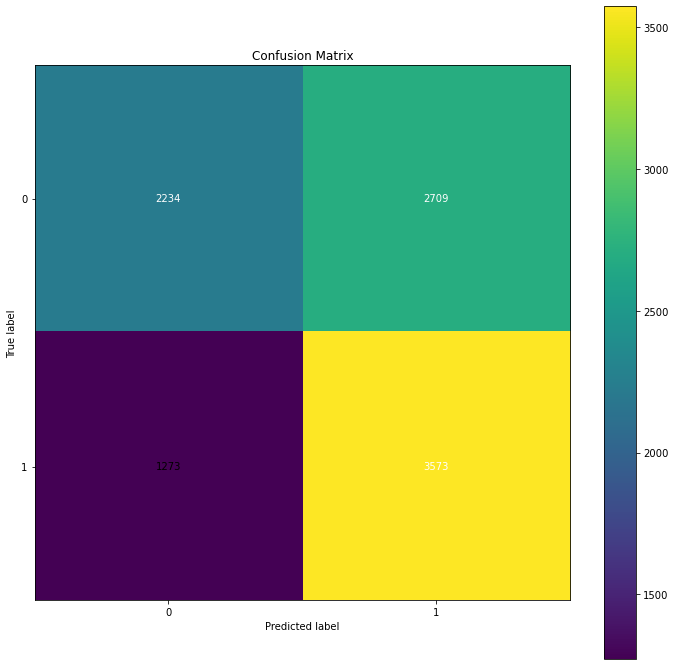

In [112]:
#confusion matrix
mt.plot_confusion_matrix(y_val, yhat_lg,  cmap=plt.cm.viridis, normalize=False, figsize=(12,12))

In [139]:
#model df full
lg_model_full = lm.LogisticRegression(n_jobs=-1, random_state=42).fit(x_train_full, y_train_full)

#prediction
yhat_lg_full = lg_model_full.predict(x_val_full)

#performance
lg_result_full = ml_error('Logistic Regression', y_val_full, yhat_lg_full)
lg_result_full

ValueError: X has 14 features per sample; expecting 3

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

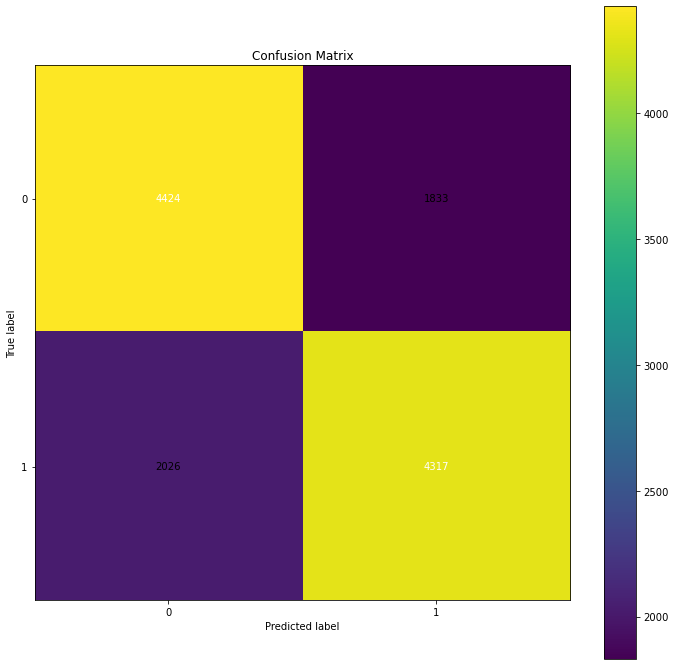

In [114]:
#confusion matrix
mt.plot_confusion_matrix(y_val_full, yhat_lg_full,  cmap=plt.cm.viridis, normalize=False, figsize=(12,12))

In [115]:
#relief
#model
lg_model_relief = lm.LogisticRegression(n_jobs=-1, random_state=42).fit(x_train_relief, y_train_relief)

#prediction
yhat_lg_relief = lg_model_relief.predict(x_val_relief)

#performance
lg_result_relief = ml_error('Logistic Regression', y_val_relief, yhat_lg_relief)
lg_result_relief

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,Logistic Regression,0.281132,0.573992,0.530219,0.718868,0.718201,0.436961


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

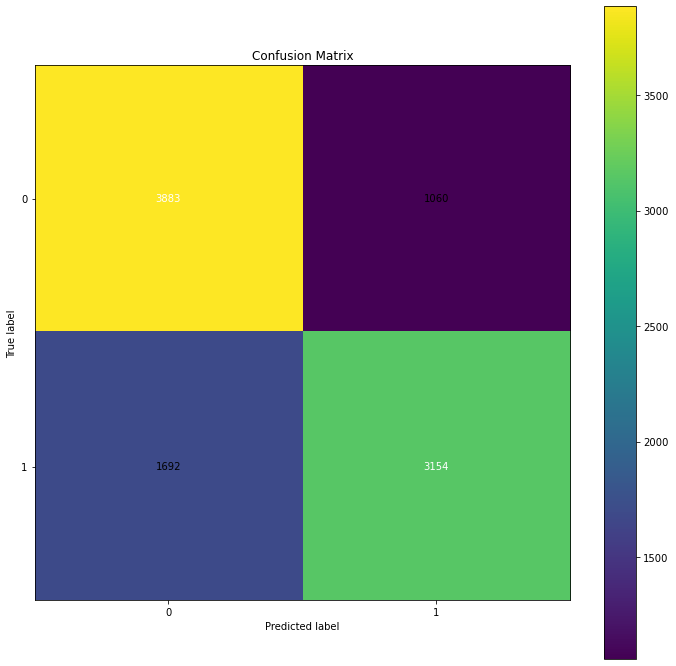

In [116]:
#confusion matrix
mt.plot_confusion_matrix(y_val_relief, yhat_lg_relief,  cmap=plt.cm.viridis, normalize=False, figsize=(12,12))

In [117]:
#lasso
#model
lg_model_lasso = lm.LogisticRegression(n_jobs=-1, random_state=42).fit(x_train_lasso, y_train_lasso)

#prediction
yhat_lg_lasso = lg_model_lasso.predict(x_val_lasso)

#performance
lg_result_lasso = ml_error('Logistic Regression', y_val_lasso, yhat_lg_lasso)
lg_result_lasso

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,Logistic Regression,0.285422,0.566561,0.534249,0.714578,0.714321,0.428838


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

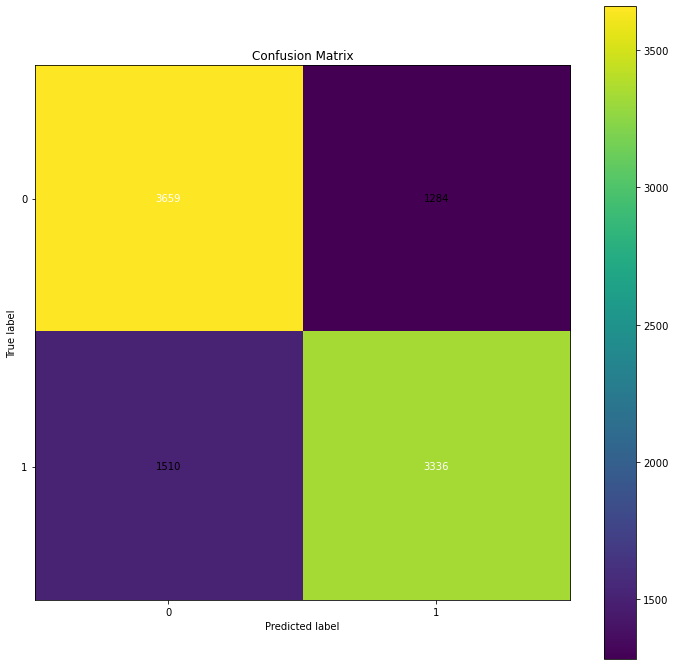

In [118]:
#confusion matrix
mt.plot_confusion_matrix(y_val_lasso, yhat_lg_lasso,  cmap=plt.cm.viridis, normalize=False, figsize=(12,12))

## 7.3. Random Forest

In [119]:
#model
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf_model.predict(x_val)

#performance
rf_result = ml_error('Random Forest', y_val, yhat_rf)
rf_result

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,Random Forest,0.277046,0.554091,0.526351,0.722954,0.722735,0.445641


In [120]:
#model df full
rf_model_full = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train_full,y_train_full)

#prediction
yhat_rf_full = rf_model_full.predict(x_val_full)

#performance
rf_result = ml_error('Random Forest', y_val_full, yhat_rf_full)
rf_result

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,Random Forest,0.274762,0.54081,0.524177,0.725238,0.725339,0.450576


In [121]:
#model lasso
rf_model_lasso = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train_lasso,y_train_lasso)

#prediction
yhat_rf_lasso = rf_model_lasso.predict(x_val_lasso)

#performance
rf_result = ml_error('Random Forest', y_val_lasso, yhat_rf_lasso)
rf_result

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,Random Forest,0.277659,0.548481,0.526933,0.722341,0.722006,0.444286


In [122]:
#model relief
rf_model_relief = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train_relief,y_train_relief)

#prediction
yhat_rf_relief = rf_model_relief.predict(x_val_relief)

#performance
rf_result = ml_error('Random Forest', y_val_relief, yhat_rf_relief)
rf_result

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,Random Forest,0.296966,0.610139,0.544946,0.703034,0.702301,0.405173


In [125]:
rf_bg = BaggingClassifier(RandomForestClassifier(), max_samples=0.5, max_features=1.0, n_estimators=50).fit(x_train,y_train)

#prediction
yhat_bg = rf_bg.predict(x_val)

#performance
bg_result = ml_error('Random Forest Bagging', y_val, yhat_bg)

pickle.dump(bg_result, open('bg_result.pkl','+wb'))
bg_result_pickle = pickle.load(open('C:/Users/Henrique/repos/Cardio Catch Diseases/bg_result.pkl','rb'))
bg_result

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,Random Forest Bagging,0.267852,0.537902,0.517544,0.732148,0.731814,0.463914


In [ ]:
bg_result_pickle

In [141]:
#rf_bg_full = BaggingClassifier(RandomForestClassifier(), max_samples=0.5, max_features=1.0, n_estimators=50).fit(x_train_full,y_train_full)

#prediction
#yhat_rf_bg_full = rf_bg_full.predict(x_val_full)

#performance
#rf_bg_full_result = ml_error('Random Forest Bagging', y_val_full, yhat_rf_bg_full)

#pickle.dump(rf_bg_full_result, open('rf_bg_full_result.pkl','+wb'))
rf_bg_full_result = pickle.load(open('C:/Users/Henrique/repos/Cardio Catch Diseases/rf_bg_full_result.pkl','rb'))
rf_bg_full_result

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,Random Forest Bagging,0.261032,0.511548,0.510913,0.738968,0.73914,0.478104


## 7.4. KNN

In [128]:
#model definition
model_knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1).fit(x_train, y_train)

#prediction
yhat_knn = model_knn.predict(x_val)

#performance
knn_result = ml_error('K-NN', y_val, yhat_knn)
knn_result

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,K-NN,0.496476,1.347616,0.70461,0.503524,0.500937,0.001883


In [129]:
#model df full
model_knn_full = KNeighborsClassifier(n_neighbors=2, n_jobs=-1).fit(x_train_full, y_train_full)

#prediction
yhat_knn_full = model_knn_full.predict(x_val_full)

#performance
knn_result = ml_error('K-NN', y_val_full, yhat_knn_full)
knn_result

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,K-NN,0.393175,0.97244,0.627036,0.606825,0.608339,0.216016


In [130]:
#model lasso
model_knn_lasso = KNeighborsClassifier(n_neighbors=2, n_jobs=-1).fit(x_train_lasso, y_train_lasso)

#prediction
yhat_knn_lasso = model_knn_lasso.predict(x_val_lasso)

#performance
knn_result = ml_error('K-NN', y_val_lasso, yhat_knn_lasso)
knn_result

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,K-NN,0.378384,0.942158,0.615129,0.621616,0.619451,0.239923


In [131]:
#model relief
model_knn_relief = KNeighborsClassifier(n_neighbors=2, n_jobs=-1).fit(x_train_relief, y_train_relief)

#prediction
yhat_knn_relief = model_knn_relief.predict(x_val_relief)

#performance
knn_result = ml_error('K-NN', y_val_relief, yhat_knn_relief)
knn_result

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,K-NN,0.359996,0.879591,0.599997,0.640004,0.637889,0.27693


In [133]:
knn_bg_relief = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=1.0, n_estimators=100).fit(x_train_relief,y_train_relief)

#prediction
yhat_knn_bg_relief = knn_bg_relief.predict(x_val)

#performance
knn_bg_result = ml_error('KNN Bagging', y_val, yhat_knn_bg_relief)
#bg_result
pickle.dump(knn_bg_result, open('knn_bg_result.pkl','+wb'))
knn_bg_result_pickle = pickle.load(open('C:/Users/Henrique/repos/Cardio Catch Diseases/knn_bg_result.pkl','rb'))

In [134]:
knn_bg_result_pickle

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,KNN Bagging,0.514864,1.022623,0.71754,0.485136,0.484916,-0.030179


## 7.5. Support Vector Machine

In [135]:
#model definition
model_svm = SVC(random_state=42).fit(x_train, y_train)

#prediction
yhat_svm = model_svm.predict(x_val)

#performance
svm_result = ml_error('SVM', y_val, yhat_svm)
svm_result

pickle.dump(svm_result, open('svm_result.pkl','+wb'))
svm_result_pickle = pickle.load(open('C:/Users/Henrique/repos/Cardio Catch Diseases/svm_result.pkl','rb'))
svm_result_pickle

<ipython-input-3-aef4631f8147>:14: RuntimeWarning: divide by zero encountered in double_scalars
  return mean_absolute_error(y,yhat)/naive_forecast(yhat)


,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,SVM,0.495045,inf,0.703595,0.504955,0.5,0.0


In [136]:
#model df full
model_svm_full = SVC(random_state=42).fit(x_train_full, y_train_full)

#prediction
yhat_svm_full = model_svm_full.predict(x_val_full)

#performance
svm_result_full = ml_error('SVM', y_val_full, yhat_svm_full)
svm_result_full

pickle.dump(svm_result_full, open('svm_result_full.pkl','+wb'))
svm_result_full_pickle = pickle.load(open('C:/Users/Henrique/repos/Cardio Catch Diseases/svm_result_full.pkl','rb'))
svm_result_full_pickle

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,SVM,0.505873,1.016668,0.711248,0.494127,0.49411,-0.01178


In [137]:
#model lasso
model_svm_lasso = SVC(random_state=42).fit(x_train_lasso, y_train_lasso)

#prediction
yhat_svm_lasso = model_svm_lasso.predict(x_val_lasso)

#performance
svm_result_lasso = ml_error('SVM', y_val_lasso, yhat_svm_lasso)
svm_result_lasso

pickle.dump(svm_result_lasso, open('svm_result_lasso.pkl','+wb'))
svm_result_lasso_pickle = pickle.load(open('C:/Users/Henrique/repos/Cardio Catch Diseases/svm_result_lasso.pkl','rb'))
svm_result_lasso_pickle

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,SVM,0.292471,0.601157,0.540806,0.707529,0.706639,0.413991


In [138]:
#model relief
model_svm_relief = SVC(random_state=42).fit(x_train_relief, y_train_relief)

#prediction
yhat_svm_relief = model_svm_relief.predict(x_val_relief)

#performance
svm_result_relief = ml_error('SVM', y_val_relief, yhat_svm_relief)
svm_result_relief

pickle.dump(svm_result_relief, open('svm_result_relief.pkl','+wb'))
svm_result_relief_pickle = pickle.load(open('C:/Users/Henrique/repos/Cardio Catch Diseases/svm_result_relief.pkl','rb'))
svm_result_relief_pickle

,Model Name,MAE,MASE,RMSE,Accuracy,Balanced,Kappa
0,SVM,0.308305,0.665863,0.555252,0.691695,0.69049,0.381877


## 7.6. AdaBoost

In [ ]:
ab = AdaBoostClassifier(AdaBoostClassifier(), n_estimators=100, learning_rate = 1).fit(x_train,y_train)

#prediction
yhat_ab = ab.predict(x_test)

#performance
ab_result = ml_error('Ada Boost', y_test, yhat_ab)
ab_result
pickle.dump(ab_result, open('ab_result.pkl','+wb'))
ab_result_pickle = pickle.load(open('C:/Users/Henrique/repos/Cardio Catch Diseases/ab_result.pkl','rb'))

In [ ]:
ab_result_pickle

## 7.7. Decision Tree

In [ ]:
dt_bg = BaggingClassifier(DecisionTreeClassifier(), max_samples=0.5, max_features=1.0, n_estimators=100).fit(x_train,y_train)

#prediction
yhat_dt_bg = dt_bg.predict(x_test)

#performance
dt_bg_result = ml_error('DT Bagging', y_test, yhat_dt_bg)
#bg_result
pickle.dump(dt_bg_result, open('dt_bg_result.pkl','+wb'))
dt_bg_result_pickle = pickle.load(open('C:/Users/Henrique/repos/Cardio Catch Diseases/dt_bg_result.pkl','rb'))

In [ ]:
dt_bg_result_pickle

In [ ]:
dt_bg_relief = BaggingClassifier(DecisionTreeClassifier(), max_samples=0.5, max_features=1.0, n_estimators=100).fit(x_train_relief,y_train_relief)

#prediction
yhat_dt_bg_relief = dt_bg_relief.predict(x_test_relief)

#performance
dt_bg_relief_result = ml_error('DT Bagging', y_test_relief, yhat_dt_bg_relief)
#bg_result
pickle.dump(dt_bg_relief_result, open('dt_bg_relief_result.pkl','+wb'))
dt_bg_relief_result = pickle.load(open('C:/Users/Henrique/repos/Cardio Catch Diseases/dt_bg_relief_result.pkl','rb'))

In [ ]:
dt_bg_relief_result

## 7.8. XGBoost

In [ ]:
#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                            n_estimators=100,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytee=0.9).fit(x_train,y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

In [ ]:
x_val.shape

In [ ]:
#model definition
model = ml.Sequential()
model.add(l.Dense(11, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(1, activation='softmax'))

#model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#train model
es = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10000, callbacks=[es], verbose=1)

# 8.0. Cross Validation

In [ ]:
models_performance_cv = pd.DataFrame({'Model':[], "Balanced": [], "Kappa": [], "Weighted_f1_score": []})

In [ ]:
models_performance_cv = cross_validation(models_performance_cv, 5, 'Logist Regression', lg_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5, 'Logist Regression Full', lg_model_full, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5, 'Logist Regression Lasso', lg_model_lasso, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5, 'Logist Regression Relief', lg_model_relief, x_train, y_train)

models_performance_cv = cross_validation(models_performance_cv, 5, 'Random Forest', rg_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5, 'Random Forest Full', rg_model_full, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5, 'Random Forest Lasso', rg_model_lasso, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5, 'Random Forest Relief', rg_model_relief, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5, 'Random Forest Bagging', rg_bg, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5, 'Random Forest Bagging Full', rg_bg_full, x_train, y_train)

models_performance_cv = cross_validation(models_performance_cv, 5, 'KNN', model_knn, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5, 'KNN Full', model_knn_full, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5, 'KNN Lasso', model_knn_lasso, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5, 'KNN Relief', model_knn_relief, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5, 'KNN Bagging Relief', knn_bg_relief, x_train, y_train)

models_performance_cv = cross_validation(models_performance_cv, 5, 'SVM', model_svm, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5, 'SVM Full', model_svm_full, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5, 'SVM Lasso', model_svm_lasso, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5, 'SVM Relief', model_svm_relief, x_train, y_train)

In [ ]:
pickle.dump(balanced_acc_list, open('balanced_acc_list_svm.pkl','+wb'))
balanced_acc_list_svm = pickle.load(open('C:/Users/Henrique/repos/Cardio Catch Diseases/balanced_acc_list_svm.pkl','rb'))

pickle.dump(weighted_f1_score_list, open('weighted_f1_score_list_svm.pkl','+wb'))
weighted_f1_score_list_svm = pickle.load(open('C:/Users/Henrique/repos/Cardio Catch Diseases/weighted_f1_score_list_svm.pkl','rb'))

pickle.dump(kappa_list, open('kappa_list_svm.pkl','+wb'))
kappa_list_svm = pickle.load(open('C:/Users/Henrique/repos/Cardio Catch Diseases/kappa_list_svm.pkl','rb'))